In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import pickle
import functools
import collections
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import sympy as sy

In [34]:
# Some globals:
PhasePortrait = collections.namedtuple(
    'PhasePortrait',
    ['exp', 'FB_type', 'days', 'collagen', 'color', 'color_by'],
    defaults=('1', 'black', None)
)
model_fields = [
    'dlogFdt_model',
    'dlogMdt_model',
    'dxdt',
    'dydt',
    'dxdt_param_med',
    'dydt_param_med',
    'dxdt_param_samples',
    'dydt_param_samples',
    'x_obs',
    'x_pred',
    'y_obs',
    'y_pred',
    'x_residuals',
    'y_residuals',
    'x_aic',
    'y_aic',
    'dxdt_param_names',
    'dydt_param_names',
    'data_to_fit',
    'fb_regressed_simple',
    'mp_regressed_simple',
    'fb_cluster',
    'mp_cluster',
]
Model = collections.namedtuple('Model', model_fields, defaults=(None,) * len(model_fields))

regressed_model_fields = [
    'model', 'xdata', 'ydata', 'params', 'ypred', 'res', 'r2', 'r2_adj', 'rse', 'aic'  # rse = regression standard error
]
RegressedModel = collections.namedtuple(
    'RegressedModel',
    regressed_model_fields,
    defaults=(None,) * len(regressed_model_fields)
)

# set the colormap and centre the colorbar
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
                 
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

# Models

In [17]:
LogDerivModel = collections.namedtuple(
    'LogDerivModel',
    ['eq_sym_log_rate', 'params', 'eq_lam_counts', 'eq_lam_log_rate'],
    defaults=(None,)*3
)
F, M, pFF, pMF, KF, rF, pFM, pMM, KM, rM, F_hat, M_hat = sy.symbols('F M pFF pMF KF rF pFM pMM KM rM F_hat M_hat')
Kd, e, pmax, n, Kff, Kmf, Kmm, Kfm = sy.symbols('Kd e pmax n Kff Kmf Kmm Kfm')

dlogFdt_log1p = lambda x, pFF, pMF, KF, rF: (pFF*np.log1p(x[0]) + pMF*np.log1p(x[1]))*(1-np.log1p(x[0])/KF) - rF
dlogF2_log1p = lambda x, pFF, pMF, KF, rF: 4*dlogFdt_log1p(x, pFF, pMF, KF, rF) + np.log(x[0])
dlogFdt_log1p_sym = (pFF*sy.log(F+1) + pMF*sy.log(M+1))*(1-sy.log(F+1)/KF) - rF

dlogMdt_log1p = lambda x, pFM, pMM, KM, rM: (pFM*np.log1p(x[0]) + pMM*np.log1p(x[1]))*(1-np.log1p(x[1])/KM) - rM
dlogM2_log1p = lambda x, pFM, pMM, KM, rM: 4*dlogMdt_log1p(x, pFM, pMM, KM, rM) + np.log(x[1])
dlogMdt_log1p_sym = (pFM*sy.log(F+1) + pMM*sy.log(M+1))*(1-sy.log(M+1)/KM) - rM

dlogFdt_log1p_model = LogDerivModel(
    eq_sym_log_rate=dlogFdt_log1p_sym,
    params=[pFF, pMF, KF, rF],
    eq_lam_counts=dlogF2_log1p,
    eq_lam_log_rate=dlogFdt_log1p,
)

dlogMdt_log1p_model = LogDerivModel(
    eq_sym_log_rate=dlogMdt_log1p_sym,
    params=[pFM, pMM, KM, rM],
    eq_lam_counts=dlogM2_log1p,
    eq_lam_log_rate=dlogMdt_log1p,
)

def dlogFdt_thr(x, pff, pmf, kf, rf):
    
    F, M = x
    _M = M.copy()
    _M[_M<=1] = 0
    res = (pff*np.log(F+1) + pmf*np.log(_M+1))*(1-np.log(F+1)/kf) - rf
    res[F<=1] = 0
    
    return res
    

def dlogMdt_thr(x, pfm, pmm, km, rm):
    
    F, M = x
    _F = F.copy()
    _F[_F<=1] = 0
    res = (pfm*np.log(_F+1) + pmm*np.log(M+1))*(1-np.log(M+1)/km) - rm
    res[M<=1] = 0
    
    return res

# Load and preprocess data

In [4]:
def calculate_mean_daily_growth_rate(data):
    
    tmp = data.copy()
    tmp['time_interval'] = ''
    tmp['#FB_final'] = np.NaN
    tmp['#BM_final'] = np.NaN
    tmp['FB_rate_per_day'] = np.NaN
    tmp['BM_rate_per_day'] = np.NaN
    tmp['log_FB_rate_per_day'] = np.NaN
    tmp['log_BM_rate_per_day'] = np.NaN
    tmp['duration'] = np.NaN

    for index, row in tmp.iterrows():
        same_exp = tmp.loc[
            (tmp['exp'] == row['exp']) &
            (tmp['FB_type'] == row['FB_type']) &
            (tmp['collagen'] == row['collagen']) &
            (tmp['plate'] == row['plate']) &
            (tmp['change_medium'] == row['change_medium']) &
            (tmp['strain'] == row['strain'])
        ]
        days = sorted(same_exp.day.unique())
        if row['day'] < days[-1]:
            next_day = days[days.index(row['day']) + 1]
            pair = same_exp.loc[
                (same_exp['id'] == row['id']) &
                (same_exp['day'] == next_day)
            ]
            if len(pair) == 0:
                print(f'WARNING: missing measurements of day {next_day} for:\n{row}\n')
            if len(pair) > 1:
                print(pair)
                raise ValueError(f'ERROR: more than one matching for:\n{row}\n')
            if len(pair) == 1:
                tmp.loc[index, 'time_interval'] = f'{row.day}->{pair.day.values[0]}'
                tmp.loc[index, 'FB_rate_per_day'] = ((pair['#FB'] / row['#FB']) ** (1/(pair['day']-row['day']))).values
                tmp.loc[index, 'BM_rate_per_day'] = ((pair['#BM'] / row['#BM']) ** (1/(pair['day']-row['day']))).values
                tmp.loc[index, 'log_FB_rate_per_day'] = ((np.log(pair['#FB']) - np.log(row['#FB']))/(pair['day']-row['day'])).values
                tmp.loc[index, 'log_BM_rate_per_day'] = ((np.log(pair['#BM']) - np.log(row['#BM']))/(pair['day']-row['day'])).values
                tmp.loc[index, '#FB_final'] = pair['#FB'].values
                tmp.loc[index, '#BM_final'] = pair['#BM'].values
                tmp.loc[index, 'duration'] = (pair['day'] - row['day']).values
    
    return tmp

In [5]:
data = pd.read_csv('../data/data.csv')

# Filtering out wells with CELL_NUMBER_THR or less cells
CELL_NUMBER_THR = 1
data.loc[(data['#FB'] <= CELL_NUMBER_THR) & (data['initial_FB'] != 0), 'outlier'] = 1
data.loc[(data['#BM'] <= CELL_NUMBER_THR) & (data['initial_BM'] != 0), 'outlier'] = 1

data = data.loc[
    (data['day'] != 0) &
    (data['collagen'] == '1') &
    ((data['plate'] == 6) | (data['plate'] == 96)) &
    ((data['change_medium'] == 0) | (data['change_medium'] == 3)) &
    (data['strain'] == 'balb') &
    (data['outlier'] == 0)
]

# scale 96 wells to 6 wells
data.loc[data['plate'] == 96, '#FB'] = data.loc[data['plate'] == 96, '#FB'] * 30
data.loc[data['plate'] == 96, '#BM'] = data.loc[data['plate'] == 96, '#BM'] * 30

data = calculate_mean_daily_growth_rate(data)
data

c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


initial_FB                  0
initial_BM               1000
id                     0_1000
#FB                         0
#BM                     480.0
day                         3
exp                         2
FB_type                   nmf
collagen                    1
plate                      96
change_medium               0
strain                   balb
outlier                     0
medium                 dmem10
time_interval                
#FB_final                 NaN
#BM_final                 NaN
FB_rate_per_day           NaN
BM_rate_per_day           NaN
log_FB_rate_per_day       NaN
log_BM_rate_per_day       NaN
duration                  NaN
Name: 150, dtype: object

initial_FB                  0
initial_BM               4000
id                     0_4000
#FB                         0
#BM                     600.0
day                         3
exp                         2
FB_type                   nmf
collagen                    1
plate                      96
change_medium 

initial_FB  initial_BM           id    #FB      #BM  day  exp FB_type  \
78           100         100      100_100    360    240.0    3    2     nmf   
79           300         100      300_100    600    240.0    3    2     nmf   
80          1000         100     1000_100   3420    240.0    3    2     nmf   
81          4000         100     4000_100  32580    510.0    3    2     nmf   
82         10000         100    10000_100  57150    720.0    3    2     nmf   
...          ...         ...          ...    ...      ...  ...  ...     ...   
3470       10000        1000   10000_1000  40650  66060.0   21  134    lung   
3471       10000       10000  10000_10000  98130  20790.0    3  134    lung   
3472       10000       10000  10000_10000  37560  57030.0    7  134    lung   
3473       10000       10000  10000_10000  77610  87030.0   14  134    lung   
3474       10000       10000  10000_10000  49020  68490.0   21  134    lung   

     collagen  plate  ...  outlier  medium  time_interval #FB_final #BM_final  \
78          1     96  ...        0  dmem10           3->7     570.0      90.0   
79          1     96  ...        0  dmem10           3->7    1590.0     270.0   
80          1     96  ...        0  dmem10           3->7    3630.0     870.0   
81          1     96  ...        0  dmem10           3->7   33240.0   13890.0   
82          1     96  ...        0  dmem10           3->7   48060.0   41640.0   
...       ...    ...  ...      ...     ...            ...       ...       ...   
3470        1     96  ...        0  dmem10                      NaN       NaN   
3471        1     96  ...        0  dmem10           3->7   37560.0   57030.0   
3472        1     96  ...        0  dmem10          7->14   77610.0   87030.0   
3473        1     96  ...        0  dmem10         14->21   49020.0   68490.0   
3474        1     96  ...        0  dmem10                      NaN       NaN   

      FB_rate_per_day  BM_rate_per_day  log_FB_rate_per_day  \
78           1.121742         0.782542             0.114883   
79           1.275885         1.029884             0.243640   
80           1.015010         1.379835             0.014898   
81           1.005026         2.284457             0.005014   
82           0.957617         2.757684            -0.043307   
...               ...              ...                  ...   
3470              NaN              NaN                  NaN   
3471         0.786558         1.286952            -0.240088   
3472         1.109245         1.062242             0.103680   
3473         0.936470         0.966355            -0.065638   
3474              NaN              NaN                  NaN   

      log_BM_rate_per_day  duration  
78              -0.245207       4.0  
79               0.029446       4.0  
80               0.321964       4.0  
81               0.826128       4.0  
82               1.014391       4.0  
...                   ...       ...  
3470                  NaN       NaN  
3471             0.252276       4.0  
3472             0.060382       7.0  
3473            -0.034224       7.0  
3474                  NaN       NaN  

[1793 rows x 22 columns]

# Fit regression models

In [6]:
def construct_arrow_data(raw_data, filt):
    '''
    @params:
        filt - filter the data according to it, should be of PhasePortrait type
    '''
    
    _data = raw_data.loc[
        ((raw_data['day'] == filt.days[0]) | (raw_data['day'] == filt.days[1])) &
        (raw_data['exp'] == filt.exp) &
        (raw_data['FB_type'] == filt.FB_type)
    ].copy()
    
    id_counts = _data['id'].value_counts()
    assert not (id_counts > 2).any(), f'Exp {filt.exp} has duplicated initial concentrations: {id_counts[id_counts > 2].index}'
    
    _data = _data.pivot_table(index='id', columns='day').loc[:, ['#BM', '#FB']]
    _data.drop(index=id_counts.index[id_counts == 1], inplace=True)
    
    _data.columns = _data.columns.to_flat_index()
    for cell_type in ['#FB', '#BM']:
        for day, label in zip(sorted(filt.days), ['i', 'f']):
            _data.rename(columns={(cell_type, day): cell_type + '_' + label}, inplace=True)
            
    return _data


def filter_data(data, cell_type, use_mono_fb=True, use_mono_mp=True, day_intervals=[[3,7]]):
    
    _data = data[data.day.isin(set(functools.reduce(lambda a, b: a+b, day_intervals)))].copy()
    
    # Start by filtering out mono-cultured cells and adding later the ones that we want
    data_to_fit = _data.loc[(_data.FB_type == cell_type) & (_data.initial_FB != 0) & (_data.initial_BM != 0)].copy()
    
    if use_mono_fb:
        data_to_fit = pd.concat([data_to_fit, _data.loc[(_data.FB_type == cell_type) & (_data.initial_BM == 0)]])
    
    if use_mono_mp:
        data_to_fit = pd.concat([data_to_fit, _data.loc[(_data.initial_FB == 0)]]) # all mono-cultured MPs
        
    return data_to_fit


def arange_model_data(data, tissue, day_intervals=[[3,7]]):
    
    _data = data.copy()
    days = [3, 7]
    arrows = []
    for exp in sorted(_data.exp.unique()):
        arrows.append(construct_arrow_data(_data, PhasePortrait(exp, tissue, days)))
    
    arrows = pd.concat(arrows)
    
    # for FB fit - extracting the independent variables (F, M in the tail day) and the dependent variable (F in the head day)
    fb_i = arrows['#FB_i'].values
    idx = fb_i != 0
    fb_i = fb_i[idx]
    mp_i = arrows['#BM_i'].values[idx]
    fb_obs = np.log(arrows['#FB_f'].values[idx]) # the target is the log
    data_for_fb = (fb_i, mp_i, fb_obs)

    # for BM fit - extracting the independent variables (F, M in the tail day) and the dependent variable (M in the head day)
    mp_i = arrows['#BM_i'].values
    idx = mp_i != 0
    mp_i = mp_i[idx]
    fb_i = arrows['#FB_i'].values[idx]
    mp_obs = np.log(arrows['#BM_f'].values[idx]) # the target is the log
    data_for_mp = (fb_i, mp_i, mp_obs)

    return data_for_fb, data_for_mp


def calculate_aic(residuals, param_number):
    
    N = residuals.shape[1]
    return N * np.log(np.sum(residuals**2, axis=1) / N) + 2*(param_number+1)


def run_single_nonlinear_multiple_regression(model, xdata, ydata, bounds=(-np.inf, np.inf)):
    
    try:
        sample = np.random.choice(len(ydata), len(ydata))
        popt, pcov = curve_fit(model, xdata[:, sample], ydata[sample], bounds=bounds)
        y_pred = model(xdata, *popt)
        residuals = ydata[sample] - model(xdata[:, sample], *popt)
    except RuntimeError:
        return 'e', 'e', 'e'
    
    return popt, y_pred, residuals


def nonlinear_multiple_regression(model, xdata, ydata, N_boots=5000, bounds=(-np.inf, np.inf)):
    '''
    @params:
        xdata - [K, M]
        ydata - [M]
    @return:
        inferred parameters - [N_boots, #model_params]
        predicted y - [M]
    '''
    
    y_pred = []
    popts = []
    residuals = []
    errors = 0
    res = Parallel(n_jobs=-2)(delayed(run_single_nonlinear_multiple_regression)(model, xdata, ydata, bounds) for i in range(N_boots))
    popts = [i[0] for i in res]
    y_pred = [i[1] for i in res]
    residuals = [i[2] for i in res]
    
    errors = popts.count('e')
    print(f'{errors}/{N_boots} bootstraps failed to fit')

    popts = list(filter(lambda a: a != 'e', popts))
    y_pred = list(filter(lambda a: a != 'e', y_pred))
    residuals = list(filter(lambda a: a != 'e', residuals))
    
    return np.array(popts), np.array(y_pred), np.array(residuals), calculate_aic(np.array(residuals), len(popts[0]))


def multiple_regression(model, xdata, ydata, xpred=None, bounds=(-np.inf, np.inf)):
    '''
    @params:
        xdata - [K, M]
        ydata - [M]
    @return:
        inferred parameters - [#model_params]
        predicted y - [M]
    '''
    
    popt, pcov = curve_fit(model, xdata, ydata, bounds=bounds)
    ypred = model(xdata if xpred is None else xpred, *popt)
    res = ydata - ypred
    r2 = 1 - (np.sum(res**2) / np.sum((ydata - np.mean(ydata))**2))
    n = len(ydata)
    p = len(popt)
    r2_adj = 1 - (1-r2)*((n-1)/(n-p-1))
    rse = np.sqrt(np.sum(res**2)/(n-p))
    aic = n*np.log(np.sum(res**2) / n) + 2*(p+1)
    
    return RegressedModel(
        xdata = xdata,
        ydata = ydata,
        params = {param_name: param for param_name, param in zip(inspect.getfullargspec(model).args[1:], popt)},
        ypred = ypred,
        res = res,
        r2 = r2,
        r2_adj = r2_adj,
        rse = rse,
        aic = aic,
    )


def fit_model(
    dlogFdt_model,
    dlogMdt_model,
    data,
    cell_type, 
    pkl=None,
    N_boots=5000,
    fb_bounds=(-np.inf, np.inf),
    mp_bounds=(-np.inf, np.inf),
    fitted_model=None,
    use_mono_fb=True, 
    use_mono_mp=False,
    day_intervals=[[3,7]],
):
    
    if fitted_model is None:
        data_to_fit = filter_data(data, cell_type, use_mono_fb, use_mono_mp, day_intervals)
        data_for_fb, data_for_mp = arange_model_data(data_to_fit, cell_type, day_intervals)
        
        dFdt = dlogFdt_model.eq_lam_counts
        dMdt = dlogMdt_model.eq_lam_counts
        
        # Fit fibroblasts:
        xdata = np.array([data_for_fb[0], data_for_fb[1]])
        fb_obs = data_for_fb[2]
        N_exps = data_to_fit[
            (data_to_fit.time_interval.isin([f'{days[0]}->{days[1]}' for days in day_intervals])) &
            (np.isfinite(data_to_fit.log_FB_rate_per_day))
        ].exp.nunique()
        print(f'Number of FB observations: {len(fb_obs)} ({N_exps} experiments)')
        inferred_params_F, fb_pred, fb_residuals, fb_aic = nonlinear_multiple_regression(
            dFdt,
            xdata,
            fb_obs,
            N_boots=N_boots,
            bounds=fb_bounds,
        )
        fb_regressed = multiple_regression(dFdt, xdata, fb_obs, bounds=fb_bounds)
        print('Whole data single fit: ' + ', '.join(f'{param}={value:0.2f}' for param, value in fb_regressed.params.items()))
        if 'KF' in fb_regressed.params:
            kf = fb_regressed.params['KF']
            print(f'KF in log10 = {np.log10(np.exp(kf)):0.2f}')
        print('Median of bootstraps: ' + ', '.join(f'{value:0.2f}' for value in np.median(inferred_params_F, axis=0)))
        print()

        # Fit macrophages:
        xdata = np.array([data_for_mp[0], data_for_mp[1]])
        mp_obs = data_for_mp[2]
        N_exps = data_to_fit[
            (data_to_fit.time_interval.isin([f'{days[0]}->{days[1]}' for days in day_intervals])) &
            (np.isfinite(data_to_fit.log_BM_rate_per_day))
        ].exp.nunique()
        print(f'Number of MP observations: {len(mp_obs)} ({N_exps} experiments)')
        inferred_params_M, mp_pred, mp_residuals, mp_aic = nonlinear_multiple_regression(
            dMdt,
            xdata,
            mp_obs,
            N_boots=N_boots,
            bounds=mp_bounds,
        )
        mp_regressed = multiple_regression(dMdt, xdata, mp_obs, bounds=mp_bounds)
        print('Whole data single fit: ' + ', '.join(f'{param}={value:0.2f}' for param, value in mp_regressed.params.items()))
        if 'KM' in mp_regressed.params:
            km = mp_regressed.params['KM']
            print(f'KM in log10 = {np.log10(np.exp(km)):0.2f}')
        print('Median of bootstraps: ' + ', '.join(f'{value:0.2f}' for value in np.median(inferred_params_M, axis=0)))
        print()
        print()

        fitted_model = Model(
            None,
            None,
            None,
            None,
            np.median(inferred_params_F, axis=0),
            np.median(inferred_params_M, axis=0),
            inferred_params_F,
            inferred_params_M,
            fb_obs,
            fb_pred,
            mp_obs,
            mp_pred,
            fb_residuals,
            mp_residuals,
            fb_aic,
            mp_aic,
            inspect.getfullargspec(dFdt).args[1:],
            inspect.getfullargspec(dMdt).args[1:],
            data_to_fit,
            fb_regressed,
            mp_regressed,
        )
        
        if pkl is not None:
            with open(f'../results/{pkl}.pkl', 'wb') as f:
                pickle.dump(fitted_model, f)
                
        fitted_model = fitted_model._replace(dlogFdt_model=dlogFdt_model, dlogMdt_model=dlogMdt_model, dxdt=dFdt, dydt=dMdt)
    
    return fitted_model

In [6]:
def new_fig(size, ncols=1, nrows=1):
    '''
    size - [widthXheight] in cm
    '''
    
    cm = 1/2.54
    f, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(np.array(size)*cm))
    matplotlib.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
    
    return f, ax


def save_fig(filepath):
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.savefig(filepath + '.pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filepath + '.png', transparent=True, dpi=300, bbox_inches='tight')


def plot_arrows(data, day_i, day_f, color_by=None, color='black', xlim=None, ylim=None, log=True, mode='regular'):
    '''
    @params:
        data - dataframe with columns: '#FB', '#BM', 'day', 'exp', 'FB_type', 'initial_FB', 'initial_BM', 'id'
        color_by - 'FB'/'BM'. color arrows by initial cells numbers according to a given 'color' dict {#initial: color}.
                   if 'color' is not a dict a default dict is built. if None color all arrows by 'color'.
        mode - regular / paper / mono_mps
    '''
    
    data = data.copy()
    if (color_by is not None) & (not isinstance(color, dict)):
        color = {
            i: c for i, c in zip(
                data['initial_' + color_by].unique(),
                sns.color_palette("tab10", data['initial_' + color_by].nunique())
            )
        }
    
    ids = set(data.loc[data['day'] == day_i, 'id']) & set(data.loc[data['day'] == day_f, 'id'])
    
    jitter_bm = list(np.linspace(0.3, 0.7, data.loc[data['initial_BM'] == 0, 'initial_FB'].nunique()))
    jitter_fb = list(np.linspace(0.3, 0.7, data.loc[data['initial_FB'] == 0, 'initial_BM'].nunique()))
    if mode == 'mono_mps':
        jitter_fb = list(np.random.uniform(0.3, 0.7, data.loc[data['initial_FB'] == 0, 'initial_BM'].nunique()))

    if log:
        plt.yscale('log')
        if (mode == 'regular') | (mode == 'paper'):
            plt.xscale('log')
        
    for i in ids:
        fb_i = data.loc[(data['id'] == i) & (data['day'] == day_i), '#FB'].values[0]
        bm_i = data.loc[(data['id'] == i) & (data['day'] == day_i), '#BM'].values[0]
        fb_f = data.loc[(data['id'] == i) & (data['day'] == day_f), '#FB'].values[0]
        bm_f = data.loc[(data['id'] == i) & (data['day'] == day_f), '#BM'].values[0]
        
        if fb_i == 0:
            jittered = jitter_fb.pop()
            fb_i += jittered
            fb_f += jittered
        if bm_i == 0:
            jittered = jitter_bm.pop()
            bm_i += jittered
            bm_f += jittered
        
#         alpha=0.7; shrink=0; width=3/5.08; headlength=10/5.08; headwidth=12/5.08; ec='white'; lw=1/5.08; ec='white';
        alpha=0.7; shrink=0; width=3; headlength=10; headwidth=12; ec='white'; lw=1;
        if mode == 'paper':
            width=3/3.81; headlength=10/3.81; headwidth=12/3.81; ec=None; lw=0.5/3.81;
        plt.annotate(
            '',
            xytext=(fb_i, bm_i),
            xy=(fb_f, bm_f),
            arrowprops=dict(
                facecolor=color if color_by is None else color[
                    data.loc[(data['id'] == i) & (data['day'] == day_i), 'initial_' + color_by].values[0]
                ],
                alpha=alpha,
                shrink=shrink,
                headlength=headlength,
                headwidth=headwidth,
                width=width,
                ec=ec,
                lw=lw,
            ),
        )   

    xlim = (data['#FB'].min(), data['#FB'].max()) if xlim is None else xlim
    ylim = (data['#BM'].min(), data['#BM'].max()) if ylim is None else ylim
    if mode == 'regular':
        plt.axvline(1, ls='--', color='black')
        plt.xlim(xlim)
        plt.grid(alpha=0.3)
        plt.axhline(1, ls='--', color='black')
        plt.xlabel('Fibroblasts #', size=24)
        plt.xticks(fontsize=18)
        plt.ylim(ylim)
        plt.ylabel('Macrophages #', size=24)
        plt.yticks(fontsize=18)
    elif mode == 'paper':
        plt.xlim(xlim)
        plt.axhline(1, ls='--', color='black', lw=0.5)
        plt.xlabel('Fibroblasts #', size=9)
        plt.xticks(ticks=10**np.arange(0, int(np.round(np.log10(xlim[1])))+1), fontsize=6)
        plt.ylim(ylim)
        plt.ylabel('Macrophages #', size=9)
        plt.yticks(ticks=10**np.arange(0, int(np.round(np.log10(ylim[1])))+1), fontsize=6)
        plt.minorticks_off()
    elif mode == "mono_mps":
        plt.xlim(xlim)
        plt.xticks([])
        plt.ylim(ylim)
        plt.ylabel('Macrophages #', size=24)
        plt.yticks(fontsize=18)
    else:
        raise ValueError(f'mode should be regular\paper\mono_mps. recieved: {mode}')


def plot_multiple_phase_plots(data, filters, xlim=(0.2, 10**5), ylim=(0.2, 10**5), legend=True, title=None, mode='regular'):
    '''
    @params:
        filters: a list of the required phase portraits. Each element should be a PhasePortrait named tuple.
    '''
    
    if mode == 'mono_mps':
        plt.figure(figsize=(4, 4*3))
    elif mode == 'regular':
        plt.figure(figsize=(4*3, 4*3))
    else:
        f, ax = new_fig((8, 8))
    for f in filters:
        plot_arrows(
            data.loc[(data['FB_type'] == f.FB_type) & (data['exp'] == f.exp) & (data['collagen'] == f.collagen)],
            day_i=f.days[0],
            day_f=f.days[1],
            color_by=f.color_by,
            color=f.color,
            xlim=xlim,
            ylim=ylim,
            mode=mode,
        )
            
    if legend:
        if isinstance(f.color, dict): # coloring by initial cell counts - single legend
            for i, color in f.color.items():
                plt.plot(1, 1, c=color, label=f'initial {f.color_by} = {i}', alpha=0.5)
        else:
            for f in filters: # comparing different experiments with different colors - multiple entities in the legend
                collagen = 'with collagen' if f.collagen == '1' else 'without collagen'
                plt.plot(1, 1, c=f.color, label=f'exp #{f.exp}, {f.FB_type}, {collagen}, {f.days}', alpha=0.5)
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        
    if title is not None:
        plt.title(title, size=30)


def plot_phase_master(data, filters, agg=None, title=None, save='', xlim=(0.2, 10**5), ylim=(0.2, 10**5), legend=True, mode='regular'):

    if agg is None:
        plot_multiple_phase_plots(data, filters, title=title, xlim=xlim, ylim=ylim, legend=legend, mode=mode)
    else:
        arrow_data = concat_arrow_data(data, filters)
        agg_data = aggregate_arrows(arrow_data, agg)
        plot_aggregated_arrows(agg_data)
        
    if len(save) != 0:
        save_fig(f'../results/{save}')


def plot_goodness_of_fit(y_obs, y_pred, r2=None, r2_adj=None, rse=None, aic=None, name=''):
    
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(4*2*2, 3*2))
    # plot predicted vs. observed:
    axs[0].plot(sorted(y_obs), sorted(y_obs), ls='--', color='gray', zorder=0)
    axs[0].scatter(y_obs, y_pred, s=15, color='black', ec='white')
    axs[0].set_xlabel('Observed $log_{10}$(cell counts in head day)', size=14)
    axs[0].set_ylabel('Predicted $log_{10}$(cell counts in head day)', size=14)
    stats = ''
    stats += f'R2={r2:0.2f}\n' if r2 is not None else ''
    stats += f'R2_adj={r2_adj:0.2f}\n' if r2_adj is not None else ''
    stats += f'rse={rse:0.2f}\n' if rse is not None else ''
    stats += f'AIC={aic:0.2f}\n' if aic is not None else ''
    axs[0].annotate(stats, (np.min(y_obs), np.max(np.concatenate((y_obs, y_pred)))), size=10, va='top')
    
    axs[1].axhline(0, ls='--', color='gray')
    axs[1].scatter(y_obs, y_obs-y_pred, s=15, color='black', ec='white')
    axs[1].set_xlabel('Observed log(cell counts in head day)', size=14)
    axs[1].set_ylabel('Residuals', size=14)
    
    plt.figure(figsize=(4*2, 3*2))
    plt.plot(sorted(y_obs), sorted(y_obs), ls='--', color='gray', zorder=0)
    plt.scatter(y_obs, y_pred, s=15, color='black', ec='white')
    plt.xlabel('Observed log(cell counts in head day)', size=14)
    plt.ylabel('Predicted log(cell counts in head day)', size=14)
    plt.annotate(stats, (np.min(y_obs), np.max(np.concatenate((y_obs, y_pred)))), size=10, va='top')
    if len(name) > 0:
        save_fig(f'../results/{name}_goodness')
    
    # For paper:
    f, ax = new_fig((8, 6))
    plt.plot(sorted(y_obs), sorted(y_obs), ls='--', color='gray', zorder=0)
    plt.scatter(y_obs, y_pred, s=3, color='black', ec='white', linewidths=0.1)
    plt.xlabel('Observed log(cell in head day)', size=9)
    plt.ylabel('Predicted log(cell in head day)', size=9)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    plt.annotate(stats, (np.min(y_obs), np.max(np.concatenate((y_obs, y_pred)))), size=5, va='top')
    if len(name) > 0:
        save_fig(f'../results/{name}_goodness_for_paper')


def plot_predicted_vs_observed(y_pred, y_obs, name='', ci=90):
    
    y_pred_med = np.median(y_pred, axis=0)
    y_pred_low_per = np.quantile(y_pred, (1-ci/100)/2, axis=0)
    y_pred_up_per = np.quantile(y_pred, 1-(1-ci/100)/2, axis=0)

    plt.figure(figsize=(4*2, 3*2))
    plt.plot(sorted(y_obs), sorted(y_obs), ls='--', color='gray', zorder=0)
    plt.errorbar(y_obs, y_pred_med, yerr=[y_pred_med-y_pred_low_per, y_pred_up_per-y_pred_med], fmt='none', color='black', label=f'{ci}% CI')
    plt.scatter(y_obs, y_pred_med, s=15, edgecolors='black', facecolors='none', label='predicted median')
    plt.legend()
    plt.xlabel('Observed log(cell counts in head day)', size=14)
    plt.ylabel('Predicted log(cell counts in head day)', size=14)
    if len(name) != 0:
        label = f'{name}_predicted_vs_observed'
        plt.title(label)
        save_fig(f'../results/{label}')


def plot_param_hists(params, param_names, single_regression_params, name='', xlims=[]):
    '''
    @params:
        params - [#samples X #params]
    '''
    
    f, axs = plt.subplots(nrows=1, ncols=params.shape[1], figsize=(4*2*params.shape[1], 3*2))
    for i, (ax, param) in enumerate(zip(axs, param_names)):
        param_med = np.median(params[:, i])
        if np.max([params[:, i].max() - param_med, param_med - params[:, i].min()]) > np.abs(10*param_med):
            cut_per = 1
            high = np.quantile(params[:, i], 1-cut_per/100/2)
            low =  np.quantile(params[:, i], cut_per/100/2)
            ax.hist(params[(params[:, i] < high) & (params[:, i] > low), i], bins=30, color='gray', alpha=0.5)
            ax.set_title(param + f' ({cut_per}% extreme params removed)', size=18)
        else:
            ax.hist(params[:, i], bins=30, color='gray', alpha=0.5)
            ax.set_title(param, size=30)
        if len(xlims) > 0:
            ax.set_xlim(xlims[i])
        ax.axvline(param_med, color='black')
        ax.annotate('{:.2f}'.format(param_med), (param_med, 5), size=20)
        ax.axvline(np.quantile(params[:, i], 0.05), color='black', alpha=0.5, ls='--', label='90%')
        ax.axvline(np.quantile(params[:, i], 0.95), color='black', alpha=0.5, ls='--')
        ax.axvline(np.quantile(params[:, i], 0.25), color='black', alpha=0.9, ls='--', label='50%')
        ax.axvline(np.quantile(params[:, i], 0.75), color='black', alpha=0.9, ls='--')
        ax.axvline(single_regression_params[param], color='black', lw=3)
        ax.legend()
        ax.tick_params(axis='x', labelsize=20)
        ax.set_yticks([])

    if len(name) != 0:
        label = f'{name}_param_hists'
        plt.suptitle(label)
        save_fig(f'../results/{label}')


def visualize_fitted_model(fitted_model, mode, name='', ci=90):
    
    # plot the experimental phase portrait
    data_to_fit = fitted_model.data_to_fit.copy()
    filters = []
    for fb_type in data_to_fit.FB_type.unique():
        _tmp = data_to_fit.loc[data_to_fit.FB_type == fb_type]
        for exp in sorted(_tmp.exp.unique()):
            __tmp = _tmp.loc[_tmp.exp == exp]
            days = sorted(__tmp.day.unique())
            if 0 in days:
                days.remove(0)
            for i in np.arange(len(days)-1):
                filters.append(PhasePortrait(exp, fb_type, [days[i], days[i+1]], collagen='1', color='black'))
    
    plot_phase_master(
        data_to_fit,
        filters=filters,
        legend=True,
        xlim=(0.2, 5*10**6),
        ylim=(0.2, 5*10**6),
        title=name,
        save='' if len(name) == 0 else name+'_exp_phase_portrait',
        mode=mode
    )
    
    fb_regressed = fitted_model.fb_regressed_simple
    mp_regressed = fitted_model.mp_regressed_simple
    plot_goodness_of_fit(fb_regressed.ydata, fb_regressed.ypred, fb_regressed.r2, fb_regressed.r2_adj, fb_regressed.rse, fb_regressed.aic, name='' if len(name) == 0 else name+'_FB')
    plot_predicted_vs_observed(fitted_model.x_pred, fitted_model.x_obs, name='' if len(name) == 0 else name+'_FB', ci=ci)
    plot_param_hists(fitted_model.dxdt_param_samples, fitted_model.dxdt_param_names, fb_regressed.params, name='' if len(name) == 0 else name+'_FB')
    
    plot_goodness_of_fit(mp_regressed.ydata, mp_regressed.ypred, mp_regressed.r2, mp_regressed.r2_adj, mp_regressed.rse, mp_regressed.aic, name='' if len(name) == 0 else name+'_MP')
    plot_predicted_vs_observed(fitted_model.y_pred, fitted_model.y_obs, name='' if len(name) == 0 else name+'_MP', ci=ci)
    plot_param_hists(fitted_model.dydt_param_samples, fitted_model.dydt_param_names, mp_regressed.params, name='' if len(name) == 0 else name+'_MP')

In [36]:
def process_model_params(param_samples, convert_k=False, make_zeros=[]):
    '''
    make_zeros - a list of indexes of params to zero (because the AIC indicate that they are not important)
    '''
    
    _param_samples = param_samples.copy()
    if convert_k:
        _param_samples[:, 2] = _param_samples[:, 2] * np.log10(np.exp(1))
    for make_zero in make_zeros:
        _param_samples[:, make_zero] = 0
    
    return _param_samples


def align_params(samples, cur_param_names, target_param_names):
    
    new_model_params = np.zeros((len(samples), 4))
    j = 0
    for i, param in enumerate(target_param_names):
        if param in cur_param_names:
            new_model_params[:, i] = samples[:, j]
            j += 1
    return new_model_params


def compare_distributions(model_samples, param_names, model_names):

    for i, param_name in enumerate(param_names):
        _model_samples = model_samples.copy()
        _model_names = model_names.copy()
        print(f'{param_name} differences:')
        for first_model, first_model_name in zip(_model_samples, _model_names):
            _model_samples = _model_samples[1:]
            _model_names = _model_names[1:]
            for second_model, second_model_name in zip(_model_samples, _model_names):
                diff = first_model[:, i] - second_model[:, i]
                ratio = first_model[:, i] / second_model[:, i]
                print(f'\t{first_model_name}>{second_model_name}: p={sum(diff<=0)/len(diff):0.2f}; {first_model_name}<{second_model_name}: p={sum(diff>=0)/len(diff):0.2f}; effect={np.mean(ratio):0.2f}+-{np.std(ratio):0.2f}')
        print()
        
        
def plot_param_comparison(param_samples, param_name, category_names, ax=None, left_xlim=None, plot_ylabel=True, plot_zero_line=False):
    
    if ax is None:
        f, ax = new_fig([2.8, 2.8])
        
    colors = sns.color_palette('tab10', len(category_names))
    for i, (param_sample, category_name, color) in enumerate(zip(reversed(param_samples), reversed(category_names), reversed(colors))):
        q02_5, q25, q50, q75, q97_5 = np.quantile(param_sample, [0.025, 0.25, 0.5, 0.75, 0.975])
        ax.errorbar(
            q50,
            i,
            fmt='.-',
            xerr=np.array([q50-q25, q75-q50])[:, np.newaxis],
            elinewidth=2,
            markersize=6,
            mfc='white',
            color=color
        )
        ax.errorbar(
            q50,
            i,
            fmt='-',
            xerr=np.array([q50-q02_5, q97_5-q50])[:, np.newaxis],
            elinewidth=1,
            color=color
        )
    if plot_ylabel:
        ax.tick_params(axis='y', length=0)
        ax.set_yticks(ticks=np.arange(len(category_names)))
        ax.set_yticklabels(labels=reversed(category_names), fontdict={'fontsize': 9})
    else:
        ax.set_yticks([])
    if plot_zero_line:
        ax.axvline(0, ls='--', color='gray', alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='x', labelsize=6)
    ax.set_xlabel(param_name, size=9)
    ax.set_ylim((-1, i+1))
    if left_xlim is not None:
        ax.set_xlim(left=left_xlim)
        

def plot_multiple_param_comparison(param_samples, param_names, category_names, fix_x_lim=None, name=None):
    '''
    param_samples - 2D list. Each row contains 1 kind of parameters to compare. The number of parameters is the number of rows.
                    The number of categories is the number of columns
    fix_x_lim - a list of left x lim to set. Same size as the number of parameters
    '''
    
    n_params = len(param_names)
    if fix_x_lim is None:
        fix_x_lim = [None] * n_params
    f, axs = new_fig(size=(4*n_params, 4), ncols=n_params)
    for i, (ax, param_sample, param_name, left_xlim) in enumerate(zip(axs, param_samples, param_names, fix_x_lim)):
        plot_param_comparison(
            param_sample,
            param_name,
            category_names,
            ax=ax,
            left_xlim=left_xlim,
            plot_ylabel=True if i==0 else False,
            plot_zero_line=False if i == 2 else True
        )

    if name is not None:
        save_fig(f'../results/{name}')


def compare_model_params(models, F_param_names=None, M_param_names=None, name=None):
    
    model_names = [model[1] for model in models]
    
    if F_param_names is None:
        F_param_names = models[0][0].dxdt_param_names
    
    model_params_F = [
        process_model_params(
            align_params(model[0].dxdt_param_samples, model[0].dxdt_param_names, ['pFF', 'pMF', 'KF', 'rF']),
            convert_k=True,
            make_zeros=model[2],
        ) for model in models
    ]
    compare_distributions(model_params_F, ['pFF', 'pMF', 'KF', 'rF'], model_names)
    
    plot_multiple_param_comparison(
        [[model_param_F[:, i] for model_param_F in model_params_F] for i in range(len(F_param_names))],
        F_param_names,
        model_names,
        name=f'param_comparison_{name}_FB' if name is not None else None
    )
    
    if M_param_names is None:
        M_param_names = models[0][0].dydt_param_names
        
    model_params_M = [
        process_model_params(
            align_params(model[0].dydt_param_samples, model[0].dydt_param_names, ['pFM', 'pMM', 'KM', 'rM']),
            convert_k=True,
            make_zeros=model[3],
        ) for model in models
    ]
    compare_distributions(model_params_M, ['pFM', 'pMM', 'KM', 'rM'], model_names)
        
    plot_multiple_param_comparison(
        [[model_param_M[:, i] for model_param_M in model_params_M] for i in range(len(M_param_names))],
        M_param_names,
        model_names,
        name=f'param_comparison_{name}_MP' if name is not None else None
    )

In [ ]:
def calculate_fixed_points(dlogFdt_sym, dlogMdt_sym, show=False):
    
    dlogFdt_sym_simple = dlogFdt_sym.subs({sy.log(F+1): F_hat, sy.log(M+1): M_hat})
    dlogMdt_sym_simple = dlogMdt_sym.subs({sy.log(F+1): F_hat, sy.log(M+1): M_hat})
    
    nonzero_fixed_points_raw = sy.solve([dlogFdt_sym_simple, dlogMdt_sym_simple], [F_hat, M_hat])
    nonzero_fixed_points_chopped = [(point[0].n(chop=True), point[1].n(chop=True)) for point in nonzero_fixed_points_raw]
    nonzero_fixed_points_converted = np.array([
        np.exp(np.array(point, dtype=float)) - 1 for point in nonzero_fixed_points_chopped if (point[0].is_real) & (point[1].is_real)
    ])
    
    F_intersection_raw = sy.solve(dlogFdt_sym_simple.subs({M_hat: 0}), F_hat)
    F_intersection_chopped = [point.n(chop=True) for point in F_intersection_raw]
    F_intersection_converted = np.array([(sy.exp(point) - 1, 0) for point in F_intersection_chopped if point.is_real], dtype=float)
    
    M_intersection_raw = sy.solve(dlogMdt_sym_simple.subs({F_hat: 0}), M_hat)
    M_intersection_chopped = [point.n(chop=True) for point in M_intersection_raw]
    M_intersection_converted = np.array([(0, sy.exp(point) - 1) for point in M_intersection_chopped if point.is_real], dtype=float)
    
    fixed_points = [
        points for points in [nonzero_fixed_points_converted, F_intersection_converted, M_intersection_converted] if len(points) > 0
    ]

    if show:
        print('Fixed points:')
        print('Nullclines intersection (not on the axes):')
        [print(f'{raw_point} -> {converted_point}') for raw_point, converted_point in zip(nonzero_fixed_points_raw, nonzero_fixed_points_converted)]
        print()
        print('Intersection of F nullcline with M axis:')
        [print(f'{raw_point} -> {converted_point}') for raw_point, converted_point in zip(F_intersection_raw, F_intersection_converted)]
        print()
        print('Intersection of M nullcline with F axis:')
        [print(f'{raw_point} -> {converted_point}') for raw_point, converted_point in zip(M_intersection_raw, M_intersection_converted)]
        
    return np.vstack(fixed_points)


def calculate_nullclines(diff_eq, xrange=[0, 7], yrange=[0, 7]):
    '''
    @params:
        diff_eq - the differential equation in F, M
    @return:
        a list of numerically evaluated nullclines M(F) on [xrange, yrange]
    '''
    
    trans_diff_eq = diff_eq.subs({sy.log(F+1): F, sy.log(M+1): M})
    sols = sy.solve(trans_diff_eq)
    print('Raw nullcline solutions:')
    print(sols)
    nullclines = []
    for sol in sols:
        
        if isinstance(sol, sy.Float):
            sol_d = {trans_diff_eq.free_symbols.pop(): sol}
            sol = sol_d
            
        assert len(sol.keys()) == 1, f'Unexpected number of solutions: {sol}'

        y_var = list(sol.keys())[0] # can be M or F
        assert (y_var is F) | (y_var is M), f'Unexpected y variable: {y_var}'

        x_var = sol[y_var].free_symbols
        assert (len(x_var) == 0) | (len(x_var) == 1), f'Unexpected number of x variables: {x_var}'

        if y_var is M:
            x = 10**(np.linspace(xrange[0], xrange[1], 1000))
        else:
            x = 10**(np.linspace(yrange[0], yrange[1], 1000))
        x = np.array([0] + [*x])

        if len(x_var) == 0:
            y = (sol[y_var]*np.ones_like(x)).astype(float)
            y = np.exp(y) - 1
        else:
            x_var = x_var.pop() # retrieving the x variable (F or M)
            trans_exp = sol[y_var].subs({x_var: sy.log(x_var + 1)}) # transforming the x variable to log(x+1)
            exp_lam = sy.lambdify(x_var, trans_exp)
            y = np.exp(exp_lam(x)) - 1 # transforming from log(y+1)

        if y_var is M:
            nullclines.append([x, y])
        else:
            nullclines.append([y, x])
            
    return nullclines


def plot_streamlines(
    dxdt,
    dydt,
    x_params,
    y_params,
    xrange=[0, 6], 
    yrange=[0, 6], 
    var_mode='count',
    heat_map=None,
    vmin=None,
    vmax=None,
    fix_axes=False,
    name='',
    color='black',
    fixed_points=None,
    density=1,
    nullclines=None
):
    '''
    @params:
        xrange / yrange - the x/y ranges of the plot. should be in log10 units
        var_mode - whether to substitute the original counts in the equations ("count") or compute the log of them first ("log")
        heat_map - None / "FB" / "BM"
    '''
    
    assert (var_mode == 'count') | (var_mode == 'log'), f'var_mode should be "log" or "count", recieved: {var_mode}'
    
    _xrange = np.log(10)*np.array(xrange)
    _yrange = np.log(10)*np.array(yrange)
    
    y, x = np.mgrid[_yrange[0]:_yrange[1]:1000j, _xrange[0]:_xrange[1]:1000j]
    if var_mode == 'count':
        y = np.exp(y)
        x = np.exp(x)
    
    dxdt_sub = dxdt([x, y], *x_params)
    dydt_sub = dydt([x, y], *y_params) 
    
    f, ax = new_fig((8, 8))
    plt.streamplot(
        np.log10(x) if var_mode == 'count' else x,
        np.log10(y) if var_mode == 'count' else y,
        dxdt_sub,
        dydt_sub,
        color=color,
        linewidth=0.5,
        arrowsize=2/2.18,
        density=density
    )
    if fixed_points is not None:
        for point in fixed_points:
            plt.plot(point[0], point[1], 'o', mfc='none', mec=color, ms=15/2.18)
    
    if fix_axes:
        plt.xticks(np.arange(xrange[1] + 1), [0] + [f'$10^{i}$' for i in range(1, xrange[1] + 1)])
        plt.yticks(np.arange(yrange[1] + 1), [0] + [f'$10^{i}$' for i in range(1, yrange[1] + 1)])
        plt.xlabel('Fibroblasts', size=9)
        plt.ylabel('Macrophages', size=9)
    else:
        plt.xlabel('$log_{10}F$', size=9)
        plt.ylabel('$log_{10}M$', size=9)
    plt.xlim((-0.1, xrange[1]))
    plt.ylim((-0.1, yrange[1]))
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    if (name != '') & (heat_map is None):
        save_fig(f'../results/{name}_streamplot')
    
    if heat_map is not None:
        deriv = dxdt([x, y], *x_params) if heat_map == 'FB' else dydt([x, y], *y_params)
        
        mid_val = 0
        vmin = np.min(deriv) if vmin is None else vmin
        vmax = np.max(deriv) if vmax is None else vmax
        plt.imshow(
            deriv,
            extent=(xrange[0], xrange[1], yrange[0], yrange[1]),
            origin='lower',
            norm=MidpointNormalize(midpoint=mid_val, vmin=vmin, vmax=vmax),
            cmap="RdBu_r"
        )
        plt.colorbar(shrink=0.8)
        if nullclines is not None:
            if fix_axes:
                for null in nullclines:
                    fixed_null_x = np.log10(null[0])
                    fixed_null_y = np.log10(null[1])
                    if null[0][0] == 0:
                        fixed_null_x[0] = 0
                    if null[1][0] == 0:
                        fixed_null_y[0] = 0
                    plt.plot(fixed_null_x, fixed_null_y, color='black', ls='--', lw=0.8)
            
        plt.title(f'change in {heat_map}s', size=9)
        if name != '':
            save_fig(f'../results/{name}_streamplot_w_{heat_map}_heatmap')
            
    else: # plot what happens whem M=0 (mono-FBs)
        f = np.array([0] + [*list(np.exp(np.linspace(_xrange[0], _xrange[1], 1000)))])
        deriv = f*dxdt([f, np.zeros_like(f)], *x_params)
        plt.figure(figsize=(4*1.5,3*1.5))
        plt.plot(f, deriv)
        plt.axhline(0, ls='--', color='gray')
        plt.xscale('symlog')
        plt.yscale('symlog')
        plt.xlim(left=0)
        plt.xlabel('Fibroblast counts', size=14)
        plt.ylabel('dF/dt(M=0)', size=14)
        plt.title('Rate of change of mono-cultured fibroblasts', size=20)
    
    return vmin, vmax


def analyze_fitted_model(
    fitted_model,
    name='',
    density=1,
    xrange=[0, 7],
    yrange=[0, 7],
    dFdt_thr=dlogFdt_thr,
    dMdt_thr=dlogMdt_thr,
    rate_minmax_fb=[None, None],
    rate_minmax_mp=[None, None],
):
    
    F_diff_eq_sub = fitted_model.dlogFdt_model.eq_sym_log_rate.subs(
        {
            param: round(value, 2) for param, value in zip(fitted_model.dlogFdt_model.params, fitted_model.dxdt_param_med)
        }
    )
    M_diff_eq_sub = fitted_model.dlogMdt_model.eq_sym_log_rate.subs(
        {
            param: round(value, 2) for param, value in zip(fitted_model.dlogMdt_model.params, fitted_model.dydt_param_med)
        }
    )
    fixed_points = calculate_fixed_points(F_diff_eq_sub, M_diff_eq_sub)
    print('Final fixed points:')
    print(fixed_points)
    fixed_points = fixed_points[np.all(fixed_points >= 0, axis=1)]
    fixed_points = np.where(fixed_points == 0, fixed_points, np.log10(fixed_points))
    print('Non-zero final fixed points:')
    print(fixed_points)
    print()
    
    F_nulls = calculate_nullclines(F_diff_eq_sub, xrange, yrange)
    M_nulls = calculate_nullclines(M_diff_eq_sub, xrange, yrange)

    plot_streamlines(
        dFdt_thr,
        dMdt_thr,
        fitted_model.dxdt_param_med,
        fitted_model.dydt_param_med,
        xrange=xrange,
        yrange=yrange,
        fix_axes=True,
        fixed_points=fixed_points,
        name=name,
        density=density
    )
    
    vminmax = np.zeros((2,2))
    for i, (cell, nullclines) in enumerate(zip(['FB', 'BM'], [F_nulls, M_nulls])):
        vminmax[:, i] = plot_streamlines(
            dFdt_thr,
            dMdt_thr,
            fitted_model.dxdt_param_med,
            fitted_model.dydt_param_med,
            xrange=xrange,
            yrange=yrange,
            fix_axes=True,
            heat_map=cell,
            vmin = rate_minmax_fb[0] if cell == 'FB' else rate_minmax_mp[0],
            vmax = rate_minmax_fb[1] if cell == 'FB' else rate_minmax_mp[1],
            name=name,
            density=density,
            nullclines=nullclines,
        )
    
    f, ax = new_fig((7, 7))
    for F_null in F_nulls:
        plt.plot(F_null[0], F_null[1], color='blue')
    plt.axvline(0, color='blue', label='F nullcline')
    for M_null in M_nulls:
        plt.plot(M_null[0], M_null[1], color='orange')
    plt.axhline(0, color='orange', label='M nullcline')
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.xlim((-0.1, 10**xrange[1]))
    plt.ylim((-0.1, 10**yrange[1]))
    plt.xlabel('Fibroblasts', size=9)
    plt.xticks(fontsize=6)
    plt.ylabel('Macrophages', size=9)
    plt.yticks(fontsize=6)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    if name != '':
        save_fig(f'../results/{name}_nullclines')
    plt.show()
    
    return vminmax

Number of FB observations: 71 (7 experiments)


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:110: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:114: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0/5000 bootstraps failed to fit


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Whole data single fit: pFF=0.30, pMF=0.02, KF=16.19, rF=1.08
KF in log10 = 7.03
Median of bootstraps: 0.31, 0.02, 16.23, 1.09

Number of MP observations: 51 (7 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFM=0.06, pMM=0.05, KM=11.71, rM=0.00
KM in log10 = 5.09
Median of bootstraps: 0.06, 0.05, 11.89, 0.00




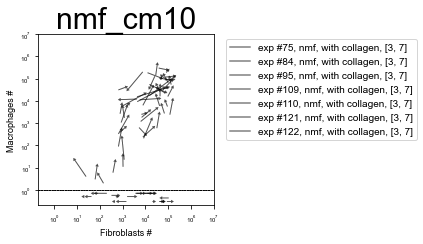

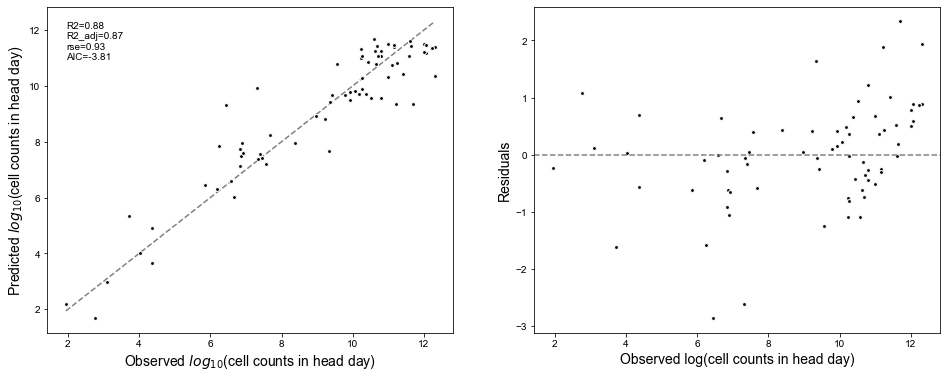

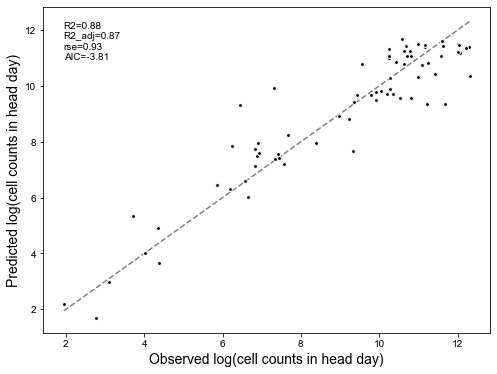

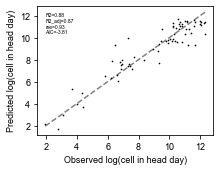

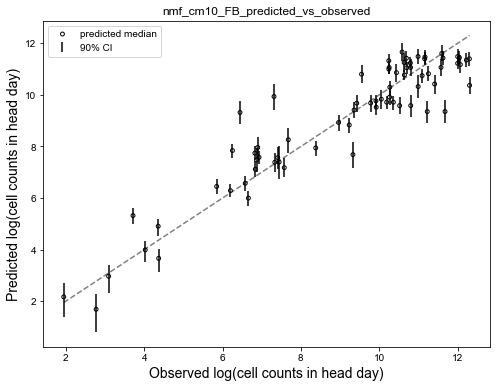

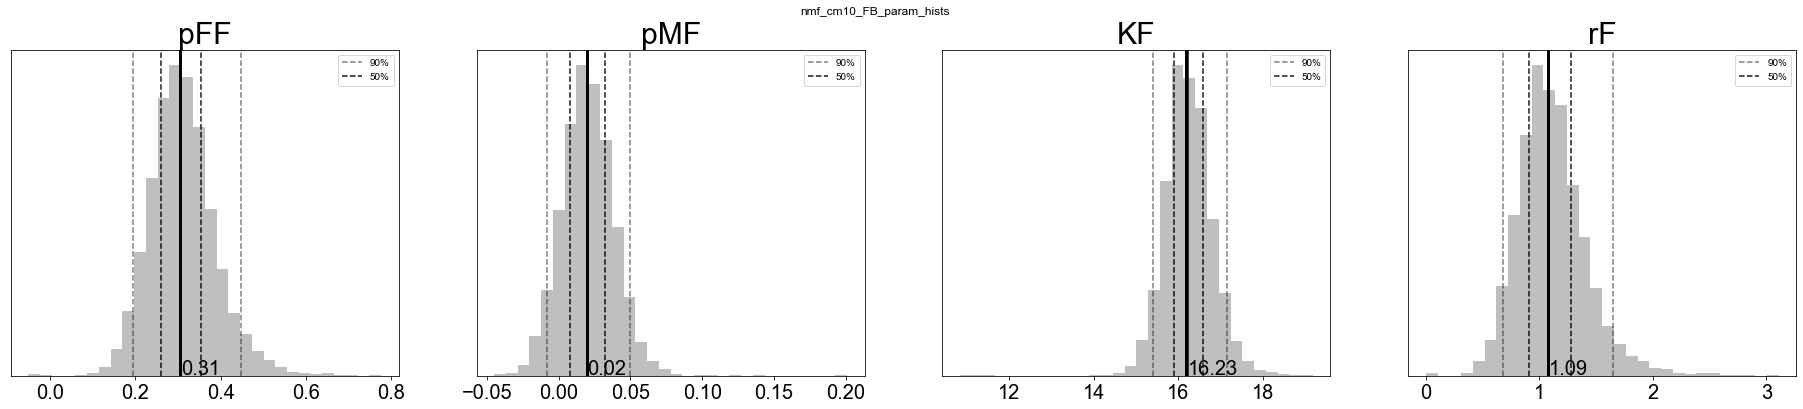

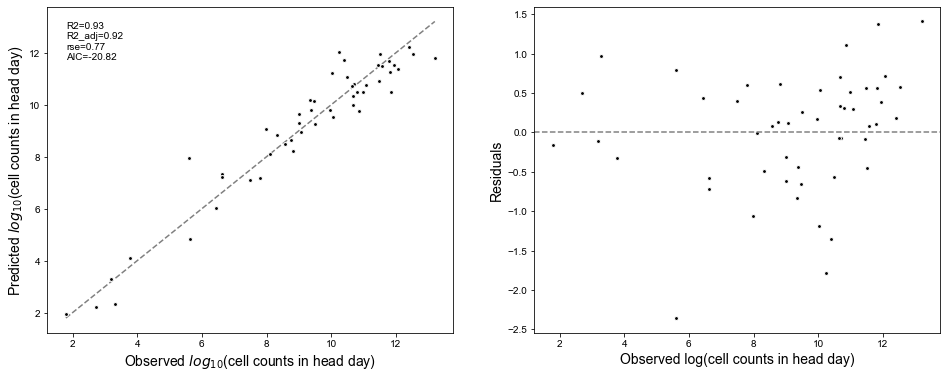

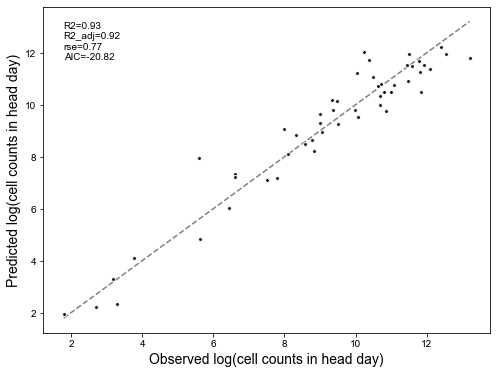

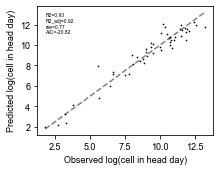

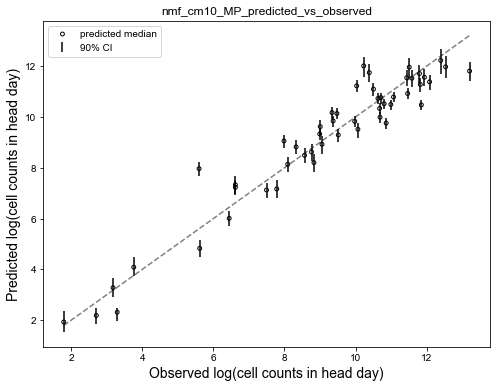

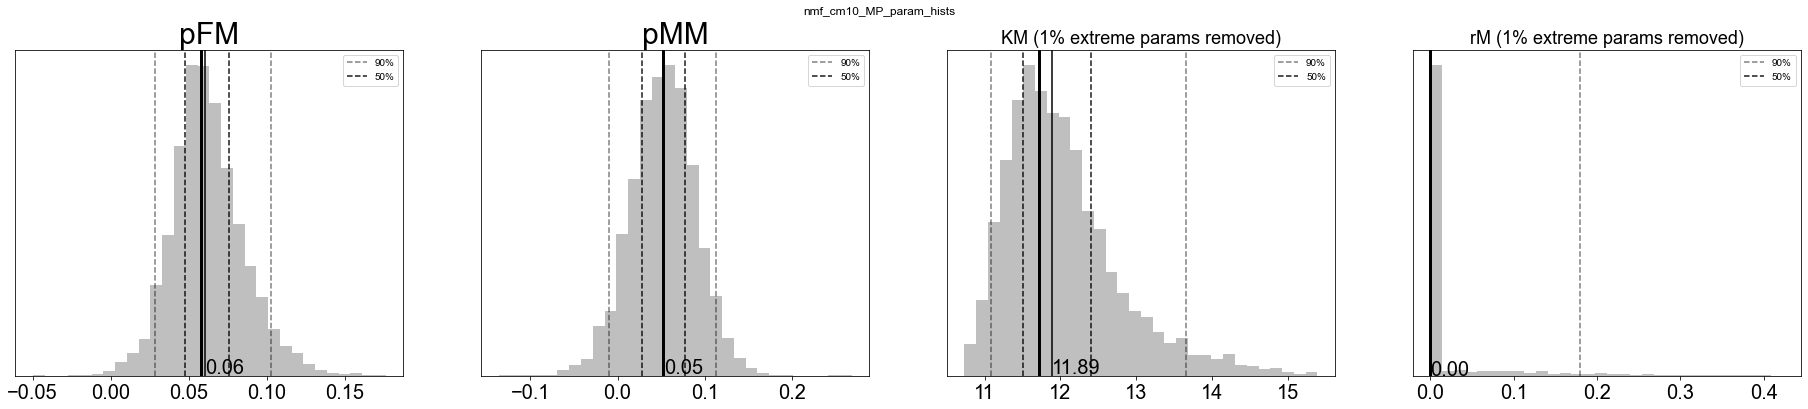

Number of FB observations: 313 (24 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFF=0.29, pMF=0.02, KF=15.43, rF=0.95
KF in log10 = 6.70
Median of bootstraps: 0.30, 0.02, 15.45, 0.96

Number of MP observations: 259 (23 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFM=0.23, pMM=0.00, KM=16.99, rM=0.74
KM in log10 = 7.38
Median of bootstraps: 0.23, 0.01, 17.01, 0.74




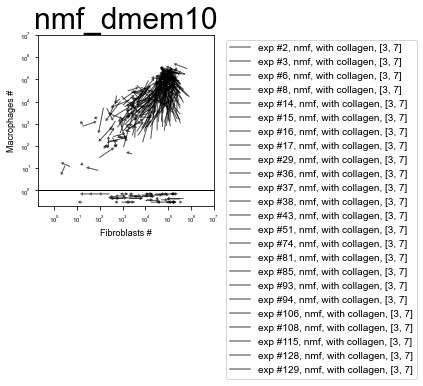

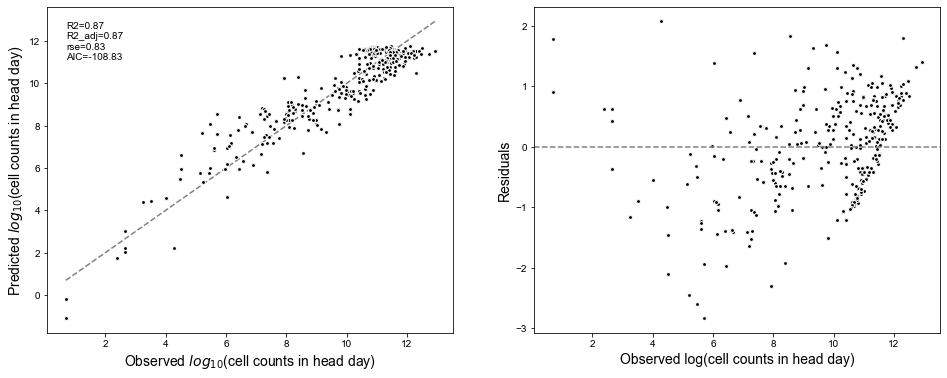

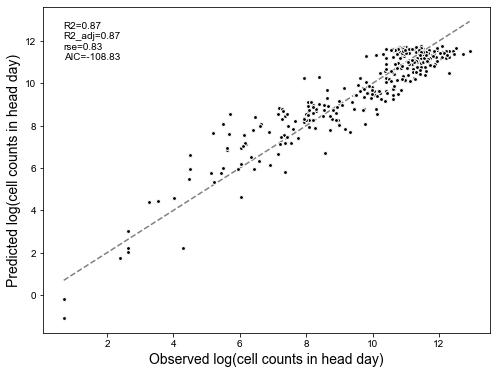

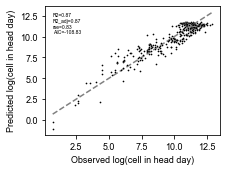

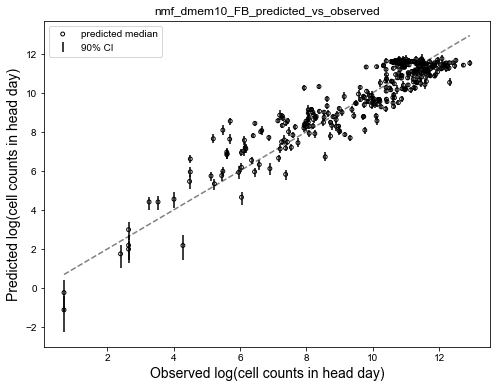

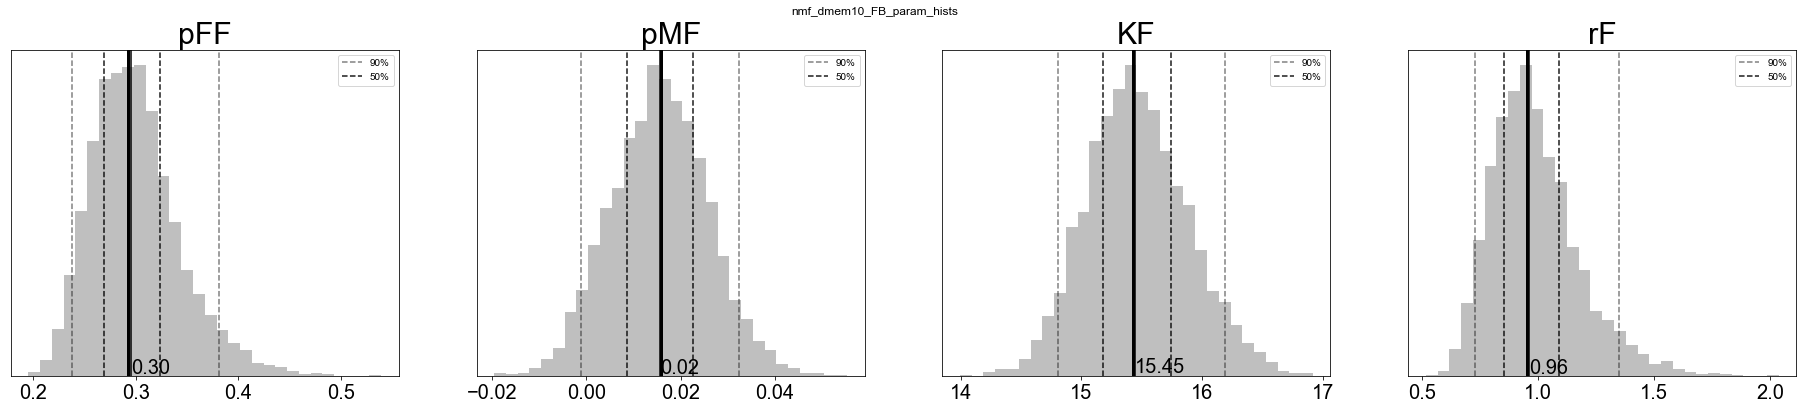

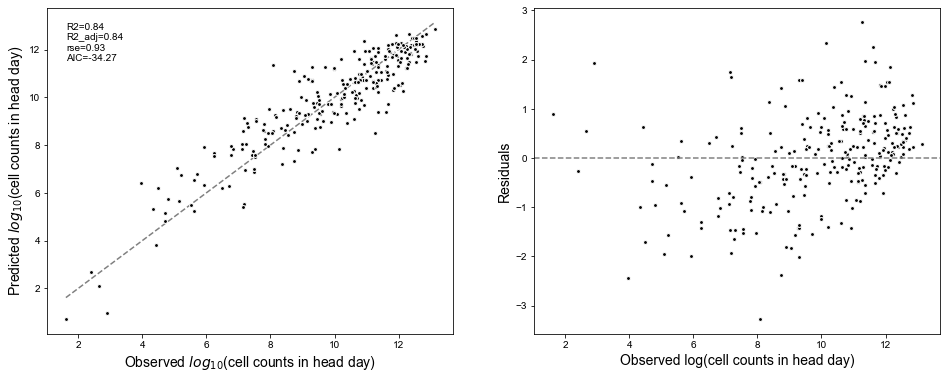

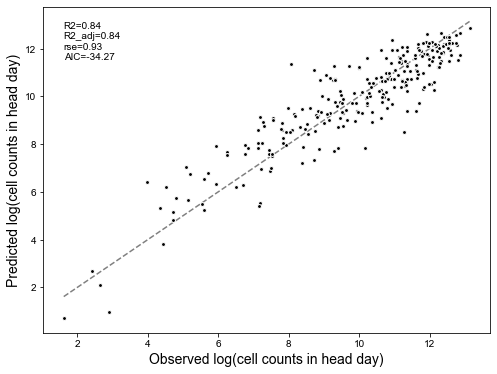

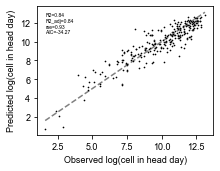

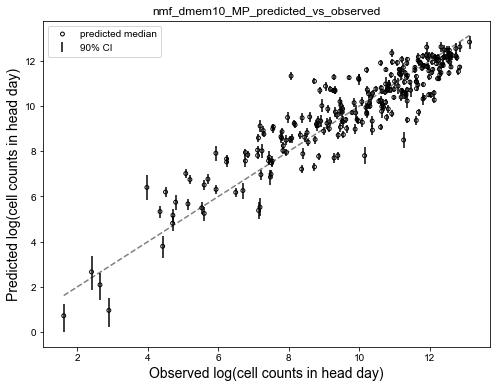

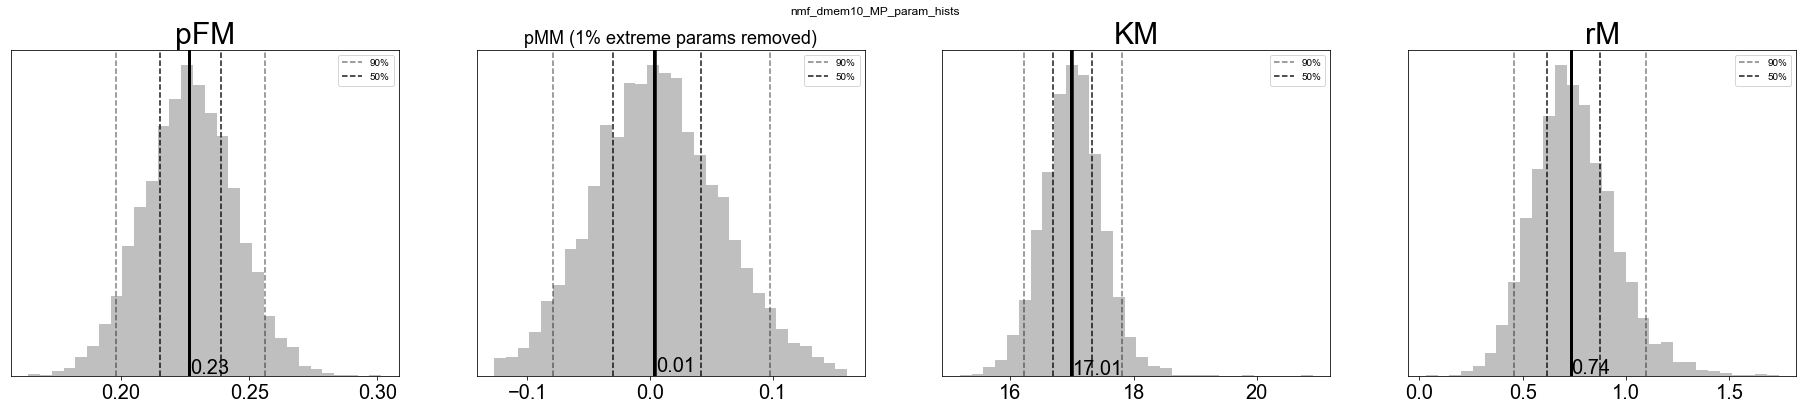

Number of FB observations: 192 (16 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFF=0.25, pMF=0.01, KF=15.40, rF=0.74
KF in log10 = 6.69
Median of bootstraps: 0.25, 0.01, 15.39, 0.73

Number of MP observations: 165 (15 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFM=0.17, pMM=0.15, KM=17.92, rM=1.16
KM in log10 = 7.78
Median of bootstraps: 0.17, 0.15, 17.89, 1.16




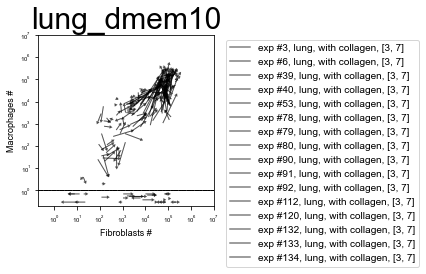

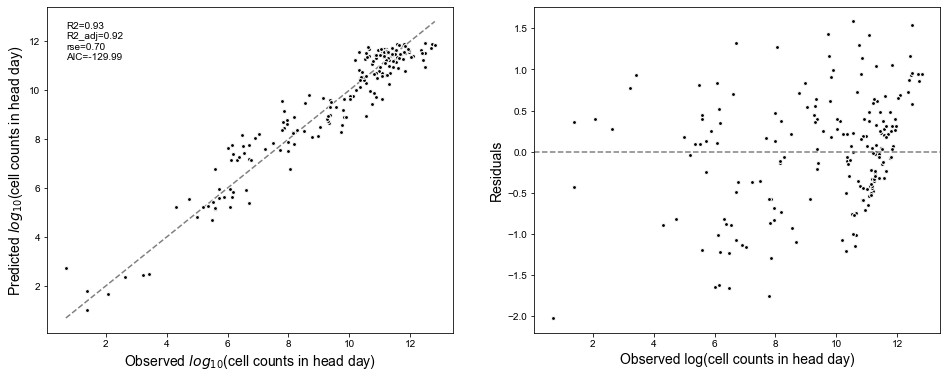

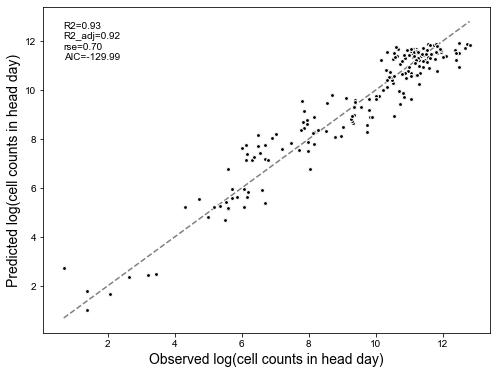

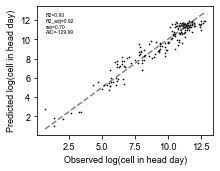

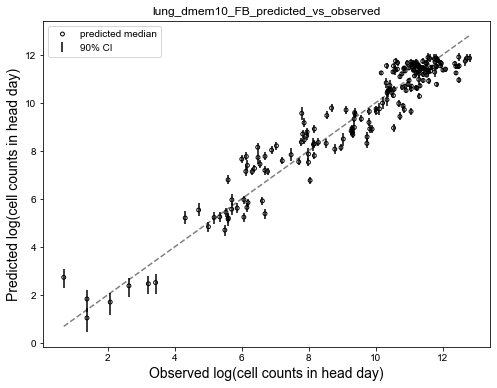

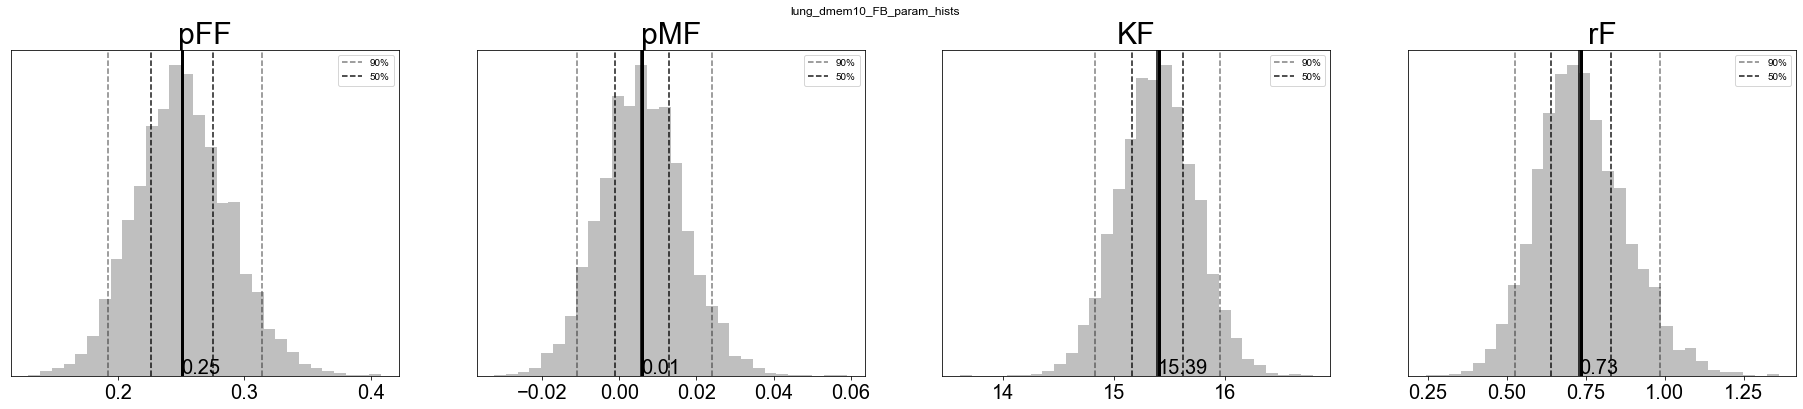

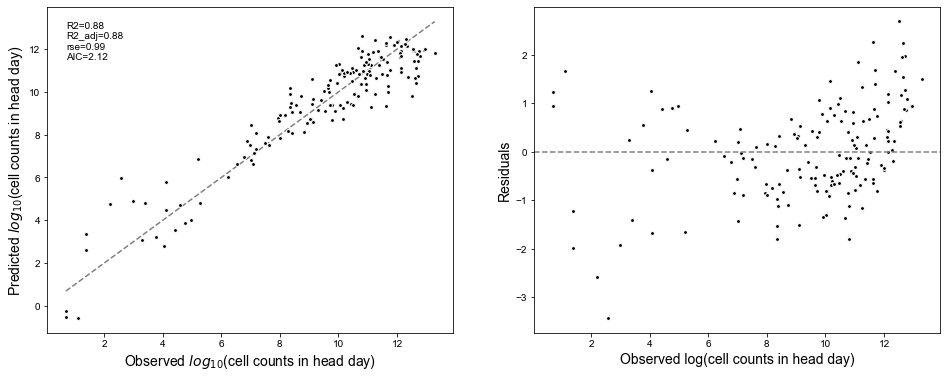

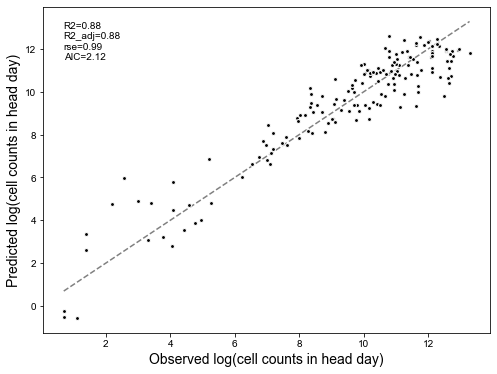

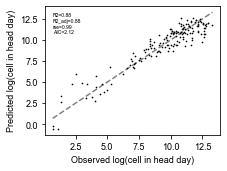

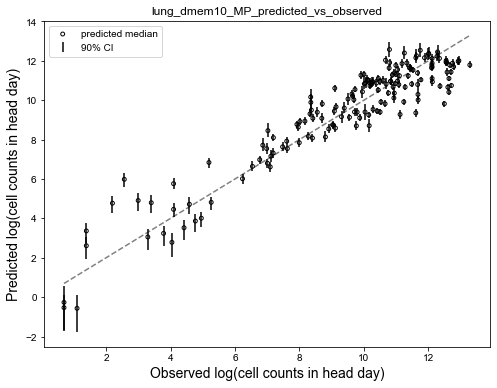

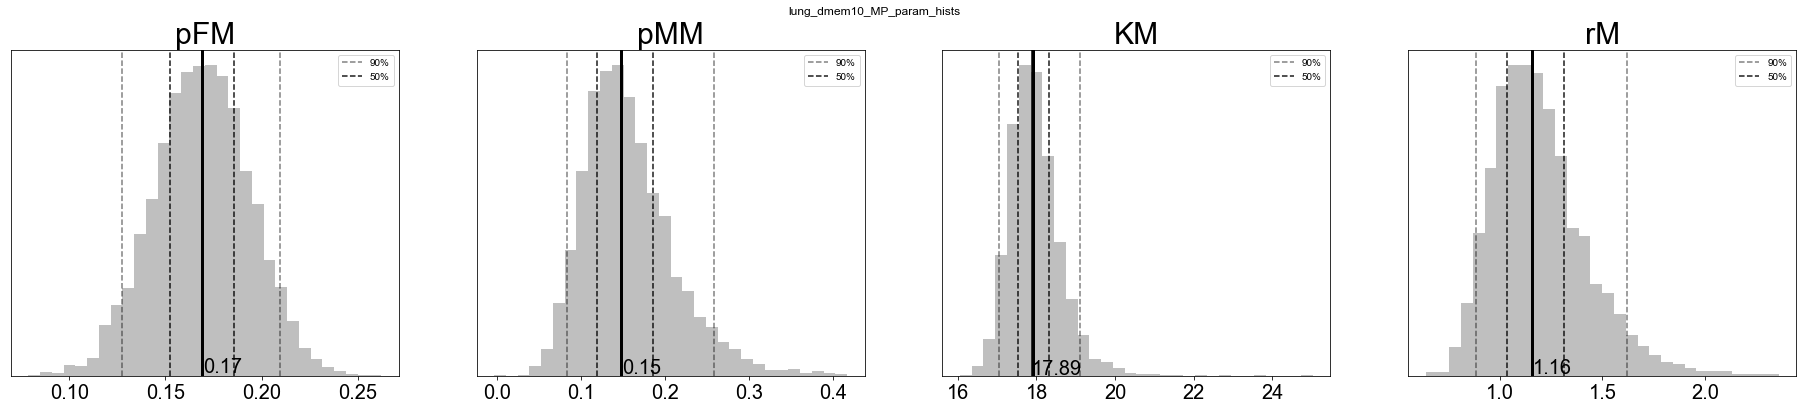

Number of FB observations: 136 (10 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFF=0.27, pMF=-0.01, KF=15.71, rF=0.79
KF in log10 = 6.82
Median of bootstraps: 0.27, -0.01, 15.70, 0.79

Number of MP observations: 117 (10 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFM=0.22, pMM=0.08, KM=17.56, rM=1.08
KM in log10 = 7.63
Median of bootstraps: 0.22, 0.08, 17.54, 1.08




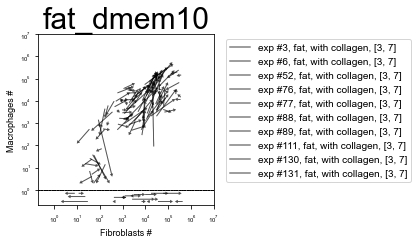

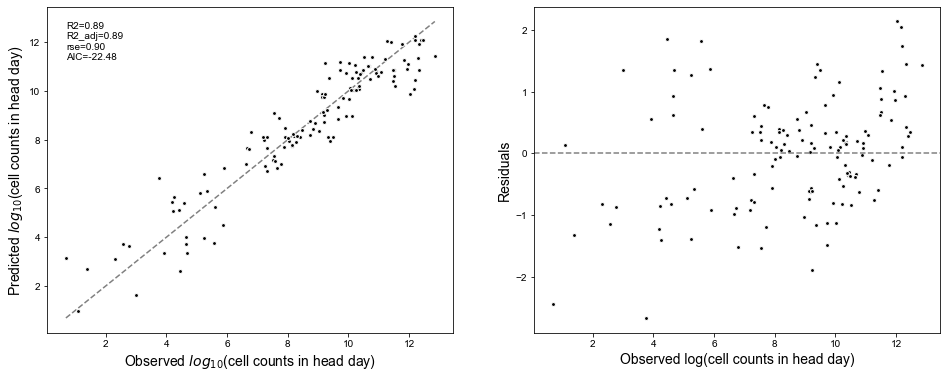

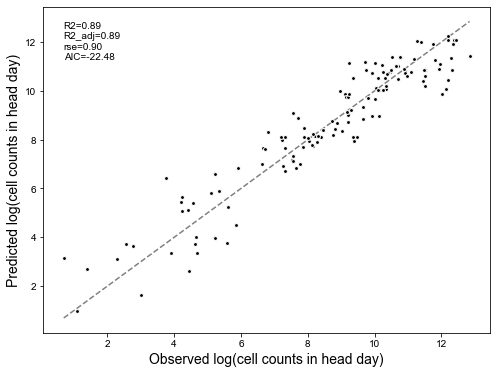

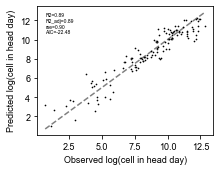

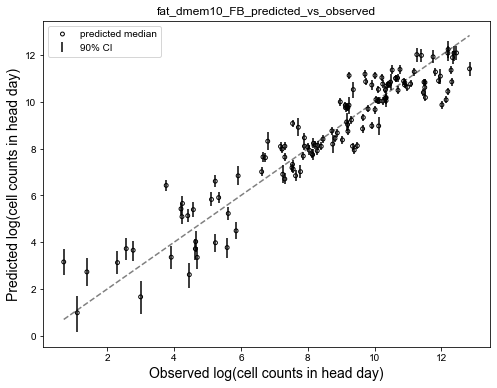

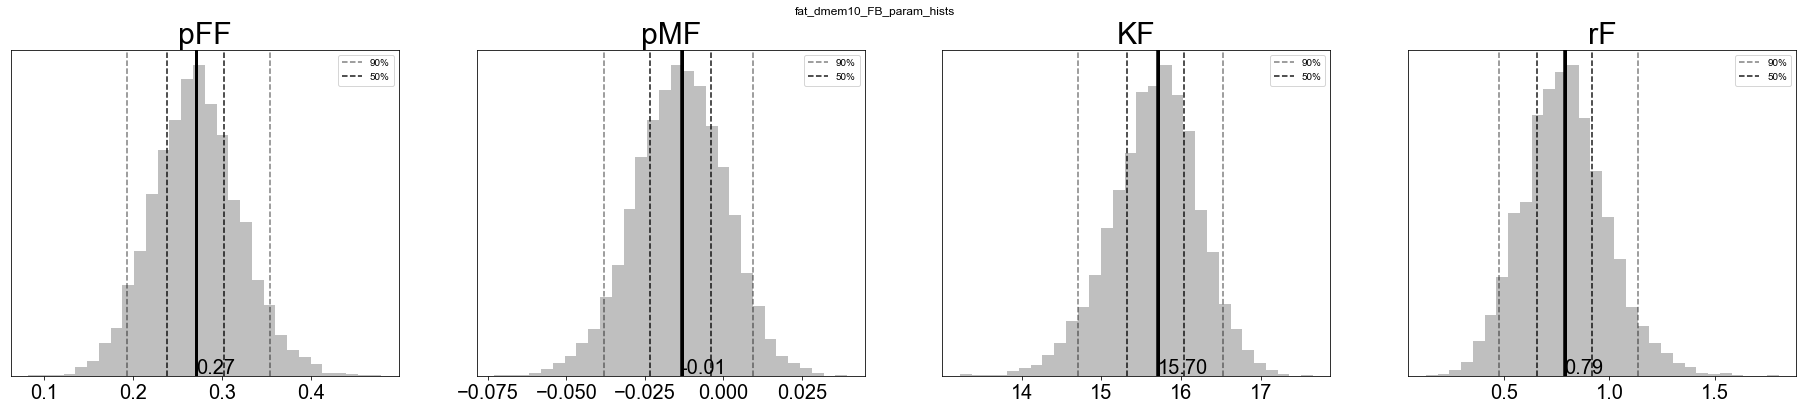

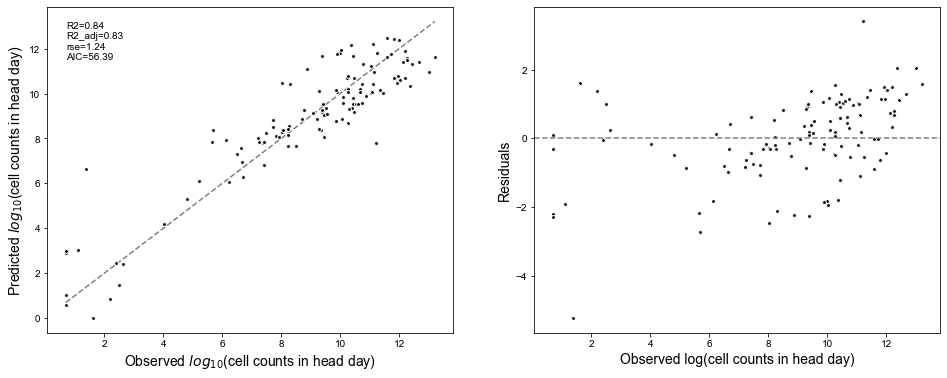

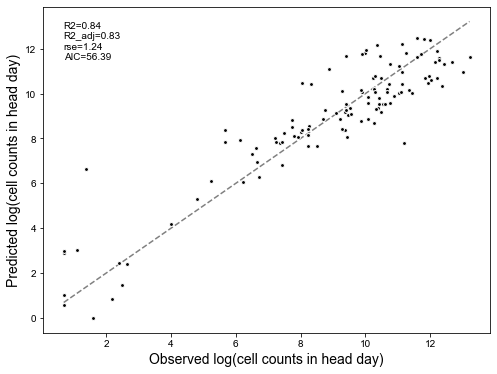

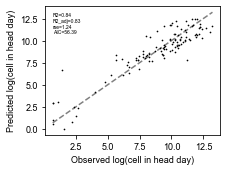

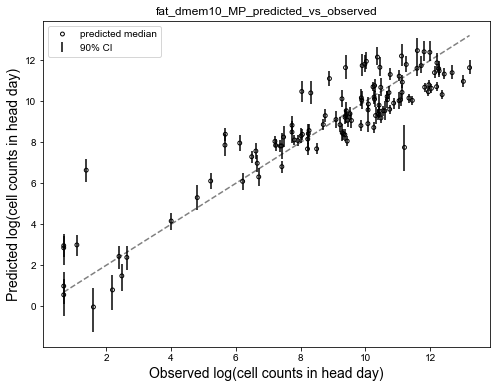

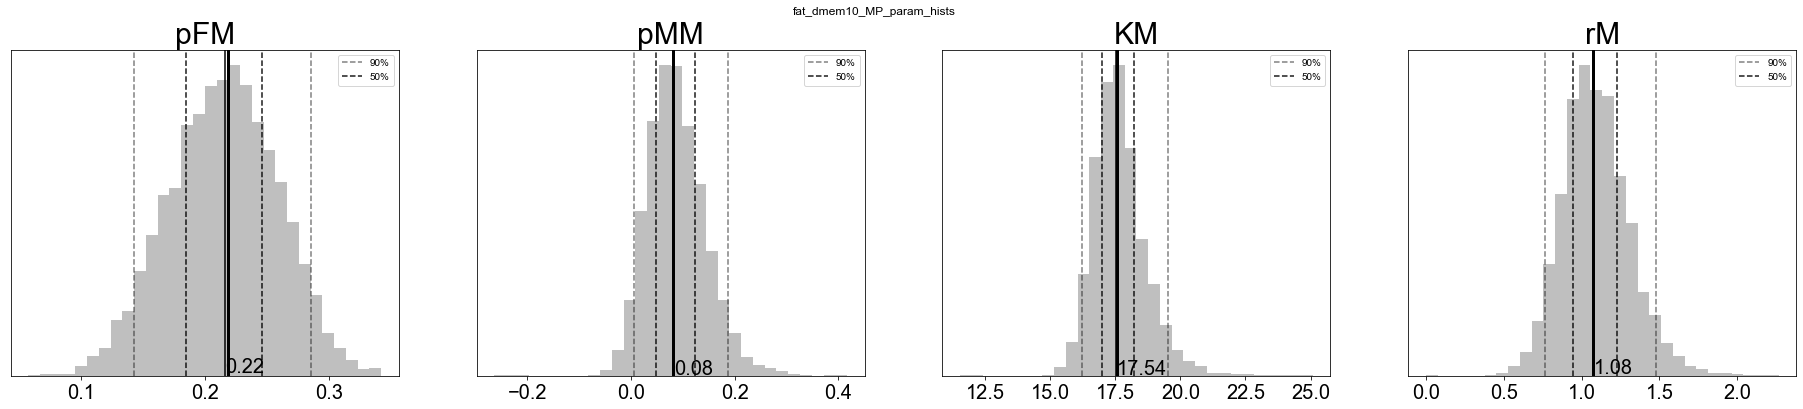

In [32]:
models = []
for organ, medium in [
    ['nmf', 'cm10'],
    ['nmf', 'dmem10'],
    ['lung', 'dmem10'],
    ['fat', 'dmem10']
]:
    fitted_model = fit_model(
        dlogFdt_log1p_model,
        dlogMdt_log1p_model,
        data.loc[(data.medium == medium)],
        cell_type=organ,
        N_boots=5000,
        fb_bounds=([-np.inf, -np.inf, 0, 0], np.inf),
        mp_bounds=([-np.inf, -np.inf, 0, 0], np.inf),
    )
    models.append(fitted_model)
    visualize_fitted_model(fitted_model, mode='paper', name=f'{organ}_{medium}')
    plt.show()

## Analyze control vs. cm

pFF differences:
	Mammary (dmem)>Mammary (cm): p=0.55; Mammary (dmem)<Mammary (cm): p=0.45; effect=0.98+-1.45

pMF differences:
	Mammary (dmem)>Mammary (cm): p=0.59; Mammary (dmem)<Mammary (cm): p=0.41; effect=-13.05+-970.27

KF differences:
	Mammary (dmem)>Mammary (cm): p=0.87; Mammary (dmem)<Mammary (cm): p=0.13; effect=0.95+-0.04

rF differences:
	Mammary (dmem)>Mammary (cm): p=0.64; Mammary (dmem)<Mammary (cm): p=0.36; effect=14335362809.76+-662287082880.29

pFM differences:
	Mammary (dmem)>Mammary (cm): p=0.00; Mammary (dmem)<Mammary (cm): p=1.00; effect=4.17+-4.16

pMM differences:
	Mammary (dmem)>Mammary (cm): p=0.77; Mammary (dmem)<Mammary (cm): p=0.23; effect=-4.13+-207.23

KM differences:
	Mammary (dmem)>Mammary (cm): p=0.00; Mammary (dmem)<Mammary (cm): p=1.00; effect=1.42+-0.12

rM differences:
	Mammary (dmem)>Mammary (cm): p=0.00; Mammary (dmem)<Mammary (cm): p=1.00; effect=5894809146973808369677869927672840192.00+-416784099889078602842023472024036311040.00



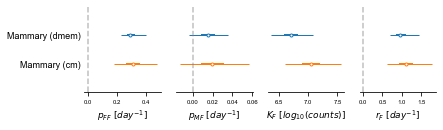

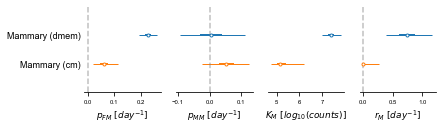

In [25]:
analyzed_models = [
    (models[1], 'Mammary (dmem)', [], []),
    (models[0], 'Mammary (cm)', [], []),
]
compare_model_params(
    analyzed_models,
    ['$p_{FF}\ [day^{-1}]$', '$p_{MF}\ [day^{-1}]$', '$K_F\ [log_{10}(counts)]$', '$r_F\ [day^{-1}]$'],
    ['$p_{FM}\ [day^{-1}]$', '$p_{MM}\ [day^{-1}]$', '$K_M\ [log_{10}(counts)]$', '$r_M\ [day^{-1}]$'],
    name='param_comparison_control_vs_cm'
)

Final fixed points:
[[-9.96394926e-01  5.08937232e+50]
 [ 6.82701641e+01  1.08103278e+02]
 [ 7.38583974e+04  2.32926147e+05]
 [ 4.40617159e+08 -1.00000000e+00]
 [ 1.21027584e+02  0.00000000e+00]
 [ 4.20127777e+04  0.00000000e+00]]
Non-zero final fixed points:
[[1.83423095 2.03383887]
 [4.86839988 5.36721824]
 [2.08288436 0.        ]
 [4.6233814  0.        ]]

Raw nullcline solutions:
[{M: 0.5*(-580.0*F**2 + 8961.0*F - 29664.0)/(20.0*F - 309.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


Raw nullcline solutions:
[{F: 0.0434782608695652*(-50.0*M**2 + 851.0*M - 62974.0)/(50.0*M - 851.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10


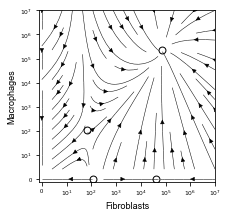

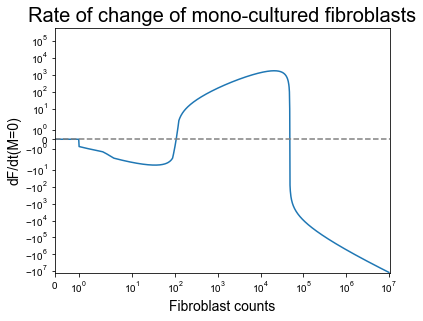

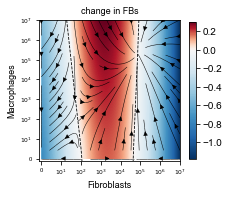

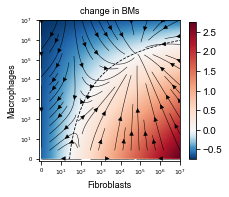

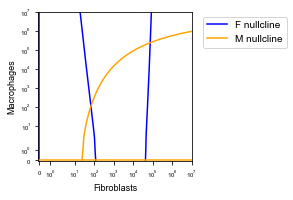

Final fixed points:
[[ 4.87240581e+01  1.42913239e+05]
 [ 5.20358800e+02 -9.99451172e-01]
 [ 2.16663440e+04 -9.99993733e-01]
 [ 1.05629736e+05  1.42913239e+05]
 [ 1.87205960e+02  0.00000000e+00]
 [ 6.00207998e+04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.42913239e+05]]
Non-zero final fixed points:
[[1.68774345 5.15507246]
 [5.02378619 5.15507246]
 [2.27231967 0.        ]
 [4.77830178 0.        ]
 [0.         0.        ]
 [0.         5.15507246]]

Raw nullcline solutions:
[{M: 0.5*(-775.0*F**2 + 12586.0*F - 44660.0)/(25.0*F - 406.0)}]
Raw nullcline solutions:


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


[{F: -0.833333333333333*M}, {M: 11.8700000000000}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10


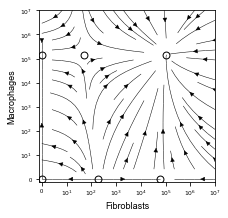

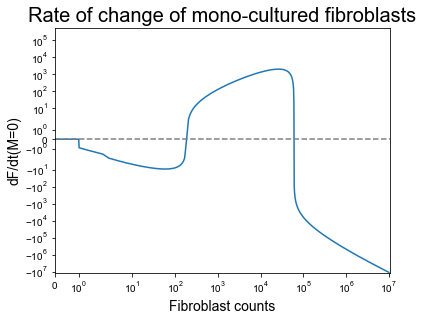

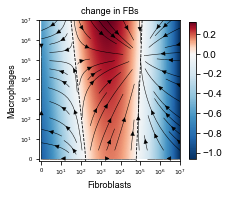

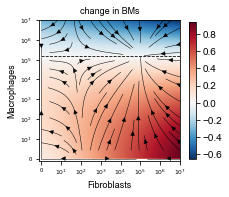

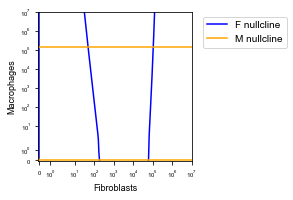

In [26]:
n_models = len(analyzed_models)
fb_min_max = np.zeros((n_models, 2))
mp_min_max = np.zeros((n_models, 2))
for i, fitted_model in enumerate(analyzed_models):
    model_minmax = analyze_fitted_model(fitted_model[0], density=0.6)
    fb_min_max[i, :] = model_minmax[:, 0]
    mp_min_max[i, :] = model_minmax[:, 1]
    plt.show()

Final fixed points:
[[-9.96394926e-01  5.08937232e+50]
 [ 6.82701641e+01  1.08103278e+02]
 [ 7.38583974e+04  2.32926147e+05]
 [ 4.40617159e+08 -1.00000000e+00]
 [ 1.21027584e+02  0.00000000e+00]
 [ 4.20127777e+04  0.00000000e+00]]
Non-zero final fixed points:
[[1.83423095 2.03383887]
 [4.86839988 5.36721824]
 [2.08288436 0.        ]
 [4.6233814  0.        ]]

Raw nullcline solutions:
[{M: 0.5*(-580.0*F**2 + 8961.0*F - 29664.0)/(20.0*F - 309.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


Raw nullcline solutions:
[{F: 0.0434782608695652*(-50.0*M**2 + 851.0*M - 62974.0)/(50.0*M - 851.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10


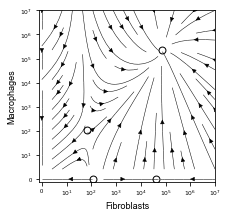

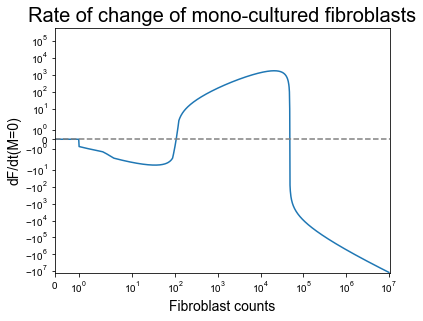

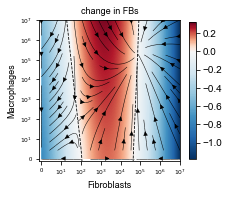

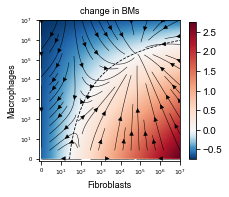

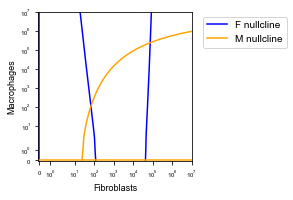

Final fixed points:
[[ 4.87240581e+01  1.42913239e+05]
 [ 5.20358800e+02 -9.99451172e-01]
 [ 2.16663440e+04 -9.99993733e-01]
 [ 1.05629736e+05  1.42913239e+05]
 [ 1.87205960e+02  0.00000000e+00]
 [ 6.00207998e+04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.42913239e+05]]
Non-zero final fixed points:
[[1.68774345 5.15507246]
 [5.02378619 5.15507246]
 [2.27231967 0.        ]
 [4.77830178 0.        ]
 [0.         0.        ]
 [0.         5.15507246]]

Raw nullcline solutions:
[{M: 0.5*(-775.0*F**2 + 12586.0*F - 44660.0)/(25.0*F - 406.0)}]
Raw nullcline solutions:
[{F: -0.833333333333333*M}, {M: 11.8700000000000}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173:

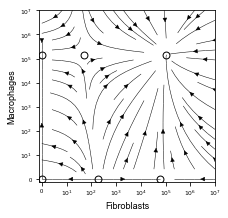

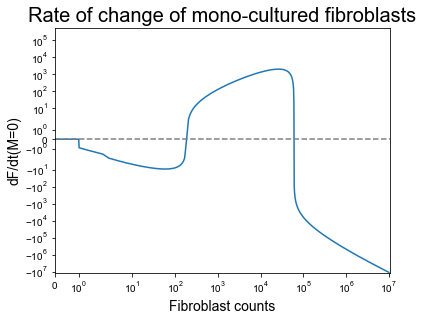

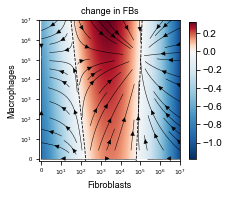

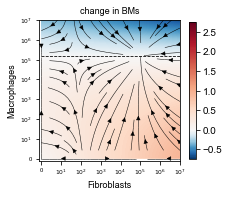

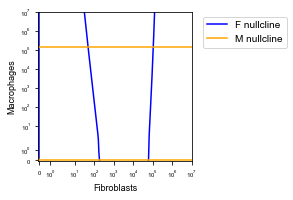

In [27]:
for i, fitted_model in enumerate(analyzed_models):
    _ = analyze_fitted_model(
        fitted_model[0],
        name=fitted_model[1],
        density=0.6,
        rate_minmax_fb=[np.min(fb_min_max[:,0]), np.max(fb_min_max[:,1])],
        rate_minmax_mp=[np.min(mp_min_max[:,0]), np.max(mp_min_max[:,1])]
    )
    plt.show()

### Direction error

In [28]:
def plot_direction_error(fitted_model, name=None):
    
    tmp_fb = np.concatenate(
        (
            np.log(fitted_model.fb_regressed_simple.xdata),
            fitted_model.fb_regressed_simple.ydata[np.newaxis, :],
            fitted_model.fb_regressed_simple.ypred[np.newaxis, :]
        )
    )
    tmp_mp = np.concatenate(
        (
            np.log(fitted_model.mp_regressed_simple.xdata),
            fitted_model.mp_regressed_simple.ydata[np.newaxis, :],
            fitted_model.mp_regressed_simple.ypred[np.newaxis, :]
        )
    )

    tmp_fb_df = pd.DataFrame(data=tmp_fb.T, columns=['fb_i', 'mp_i', 'fb_f_o', 'fb_f_p'])
    tmp_mp_df = pd.DataFrame(data=tmp_mp.T, columns=['fb_i', 'mp_i', 'mp_f_o', 'mp_f_p'])

    summary = pd.merge(left=tmp_fb_df, right=tmp_mp_df, on=['fb_i', 'mp_i'], how='outer')
    summary['fb_f_o'] = summary['fb_f_o'] - summary['fb_i']
    summary['fb_f_p'] = summary['fb_f_p'] - summary['fb_i']
    summary['mp_f_o'] = summary['mp_f_o'] - summary['mp_i']
    summary['mp_f_p'] = summary['mp_f_p'] - summary['mp_i']

    summary.fillna(0, inplace=True)

    summary['angle diff'] = summary.apply(
        lambda x: np.arccos(np.dot(
            [x['fb_f_o'], x['mp_f_o']],
            [x['fb_f_p'], x['mp_f_p']]
        )/(np.linalg.norm([x['fb_f_o'], x['mp_f_o']])*np.linalg.norm([x['fb_f_p'], x['mp_f_p']]))),
        axis=1
    )
    
    f, axs = new_fig(size=(4, 4))
    plt.hist(summary['angle diff'][np.isfinite(summary['mp_i'])]*180/np.pi, bins='auto', color='gray', alpha=0.5, density=True)
    plt.xlabel('|direction error| [degrees]', size=9)
    med = np.median(summary['angle diff'][np.isfinite(summary['mp_i'])]*180/np.pi)
    plt.axvline(med, ls='--', color='black')
    plt.text(med+1, 0.005, f'{int(med)}$\degree$', fontdict={'size': 9})
    plt.title(name, size=10)
    plt.xticks([0, 90], fontsize=6)
    plt.yticks(fontsize=6)
    if name is not None:
        save_fig(f'../results/direction_error_{name}')

c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


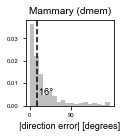

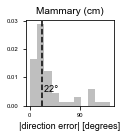

In [29]:
for model in analyzed_models:
    plot_direction_error(model[0], model[1])

## Analyze organs

pFF differences:
	Mammary>Lung: p=0.19; Mammary<Lung: p=0.81; effect=1.22+-0.26
	Mammary>Fat: p=0.34; Mammary<Fat: p=0.66; effect=1.15+-0.28
	Lung>Fat: p=0.63; Lung<Fat: p=0.37; effect=0.96+-0.24

pMF differences:
	Mammary>Lung: p=0.25; Mammary<Lung: p=0.75; effect=-0.09+-732.37
	Mammary>Fat: p=0.05; Mammary<Fat: p=0.95; effect=-0.20+-41.02
	Lung>Fat: p=0.13; Lung<Fat: p=0.87; effect=-0.04+-25.66

KF differences:
	Mammary>Lung: p=0.45; Mammary<Lung: p=0.55; effect=1.01+-0.03
	Mammary>Fat: p=0.63; Mammary<Fat: p=0.37; effect=0.99+-0.04
	Lung>Fat: p=0.67; Lung<Fat: p=0.33; effect=0.98+-0.04

rF differences:
	Mammary>Lung: p=0.13; Mammary<Lung: p=0.87; effect=1.39+-0.39
	Mammary>Fat: p=0.23; Mammary<Fat: p=0.77; effect=1.34+-0.48
	Lung>Fat: p=0.58; Lung<Fat: p=0.42; effect=1.00+-0.36

pFM differences:
	Mammary>Lung: p=0.03; Mammary<Lung: p=0.97; effect=1.37+-0.24
	Mammary>Fat: p=0.41; Mammary<Fat: p=0.59; effect=1.11+-0.28
	Lung>Fat: p=0.82; Lung<Fat: p=0.18; effect=0.82+-0.23

pMM differ

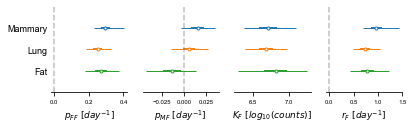

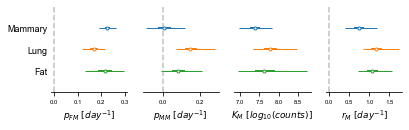

In [37]:
analyzed_models = [
    (models[1], 'Mammary', [], []),
    (models[2], 'Lung', [], []),
    (models[3], 'Fat', [], []),
]
compare_model_params(
    analyzed_models,
    ['$p_{FF}\ [day^{-1}]$', '$p_{MF}\ [day^{-1}]$', '$K_F\ [log_{10}(counts)]$', '$r_F\ [day^{-1}]$'],
    ['$p_{FM}\ [day^{-1}]$', '$p_{MM}\ [day^{-1}]$', '$K_M\ [log_{10}(counts)]$', '$r_M\ [day^{-1}]$'],
    name='param_comparison_organs'
)

Final fixed points:
[[-9.97104986e-01  1.58396220e+53]
 [ 5.74890121e+01  6.10367963e+01]
 [ 9.02667161e+04  2.50357229e+05]
 [ 5.53289102e+08 -1.00000000e+00]
 [ 9.13590471e+01  0.00000000e+00]
 [ 5.55088817e+04  0.00000000e+00]]
Non-zero final fixed points:
[[1.75958485 1.78559173]
 [4.95552764 5.39856014]
 [1.96075156 0.        ]
 [4.74436248 0.        ]]

Raw nullcline solutions:
[{M: 3.0*(-100.0*F**2 + 1545.0*F - 4944.0)/(20.0*F - 309.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


Raw nullcline solutions:
[{F: 0.0434782608695652*(-100.0*M**2 + 1701.0*M - 125874.0)/(100.0*M - 1701.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10


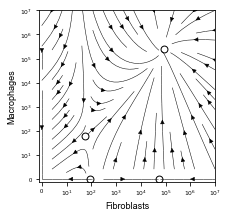

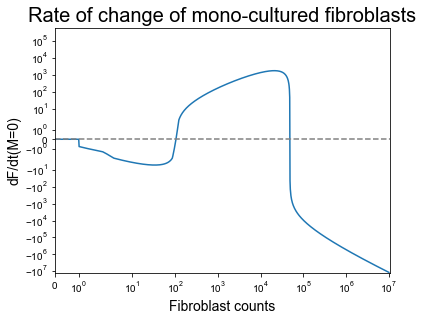

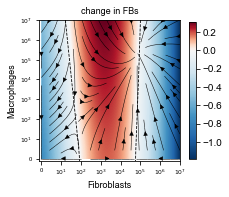

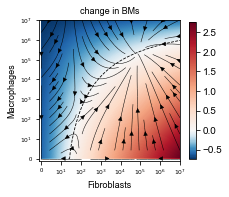

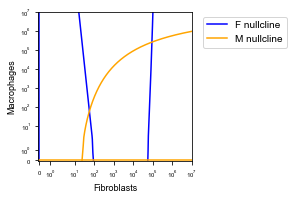

Final fixed points:
[[ 8.17383908e+04 -9.99347572e-01]
 [ 1.21754155e+05  2.75757190e+05]
 [ 4.92432126e+01  0.00000000e+00]
 [ 9.60970722e+04  0.00000000e+00]]
Non-zero final fixed points:
[[5.08548379 5.44052684]
 [1.69234638 0.        ]
 [4.98271016 0.        ]]

Raw nullcline solutions:
[{M: 25.0*(-649772579597141.0*F**2 + 1.0e+16*F - 2.92e+16)/(649772579597141.0*F - 1.0e+16)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


Raw nullcline solutions:
[{F: 0.294117647058824*(-335382895472331.0*M**2 + 6.0e+15*M - 4.64e+16)/(111794298490777.0*M - 2.0e+15)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10


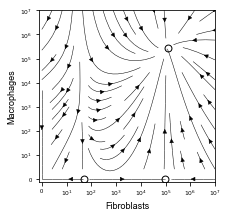

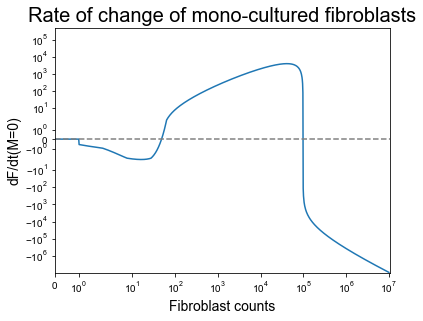

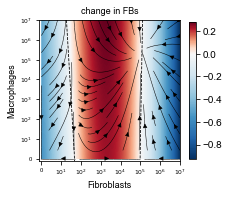

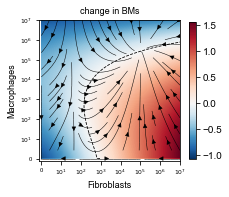

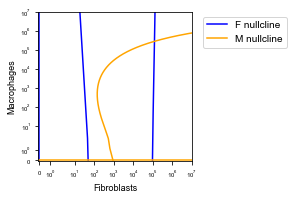

Final fixed points:
[[ 1.05689193e+05  1.89924002e+05]
 [ 2.08395849e+05 -1.00000000e+00]
 [ 4.78870376e+01  0.00000000e+00]
 [ 1.34656220e+05  0.00000000e+00]]
Non-zero final fixed points:
[[5.02403058 5.27857985]
 [1.68021797 0.        ]
 [5.12922642 0.        ]]

Raw nullcline solutions:
[{M: (270.0*F**2 - 4239.0*F + 12403.0)/(10.0*F - 157.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


Raw nullcline solutions:
[{F: 0.181818181818182*(-100.0*M**2 + 1754.0*M - 23679.0)/(50.0*M - 877.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10


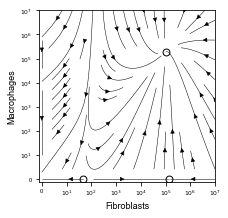

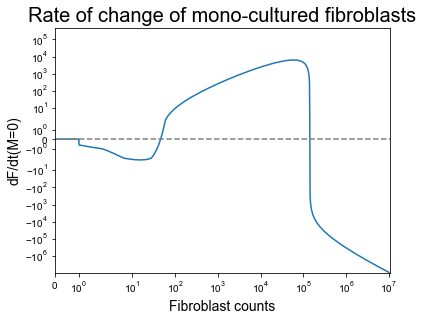

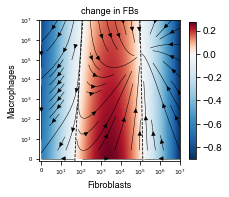

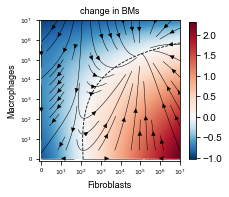

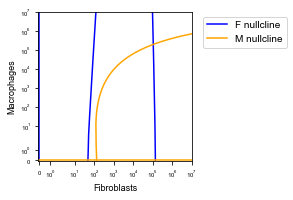

In [38]:
n_models = len(analyzed_models)
fb_min_max = np.zeros((n_models, 2))
mp_min_max = np.zeros((n_models, 2))
for i, fitted_model in enumerate(analyzed_models):
    model_minmax = analyze_fitted_model(fitted_model[0], density=0.6)
    fb_min_max[i, :] = model_minmax[:, 0]
    mp_min_max[i, :] = model_minmax[:, 1]
    plt.show()

Final fixed points:
[[-9.97104986e-01  1.58396220e+53]
 [ 5.74890121e+01  6.10367963e+01]
 [ 9.02667161e+04  2.50357229e+05]
 [ 5.53289102e+08 -1.00000000e+00]
 [ 9.13590471e+01  0.00000000e+00]
 [ 5.55088817e+04  0.00000000e+00]]
Non-zero final fixed points:
[[1.75958485 1.78559173]
 [4.95552764 5.39856014]
 [1.96075156 0.        ]
 [4.74436248 0.        ]]

Raw nullcline solutions:
[{M: 3.0*(-100.0*F**2 + 1545.0*F - 4944.0)/(20.0*F - 309.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


Raw nullcline solutions:
[{F: 0.0434782608695652*(-100.0*M**2 + 1701.0*M - 125874.0)/(100.0*M - 1701.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10


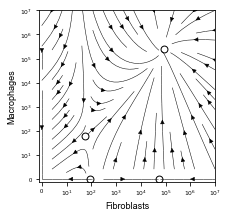

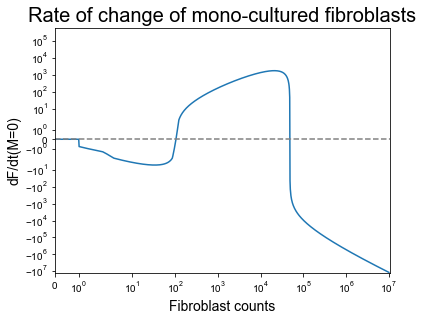

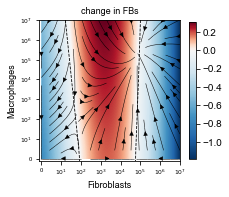

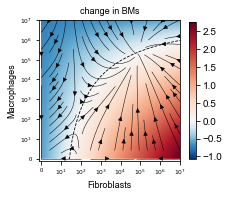

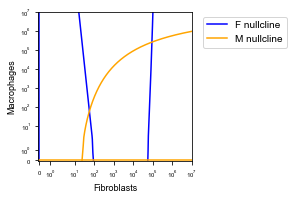

Final fixed points:
[[ 8.17383908e+04 -9.99347572e-01]
 [ 1.21754155e+05  2.75757190e+05]
 [ 4.92432126e+01  0.00000000e+00]
 [ 9.60970722e+04  0.00000000e+00]]
Non-zero final fixed points:
[[5.08548379 5.44052684]
 [1.69234638 0.        ]
 [4.98271016 0.        ]]

Raw nullcline solutions:
[{M: 25.0*(-649772579597141.0*F**2 + 1.0e+16*F - 2.92e+16)/(649772579597141.0*F - 1.0e+16)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


Raw nullcline solutions:
[{F: 0.294117647058824*(-335382895472331.0*M**2 + 6.0e+15*M - 4.64e+16)/(111794298490777.0*M - 2.0e+15)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10


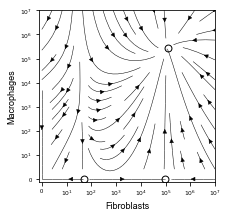

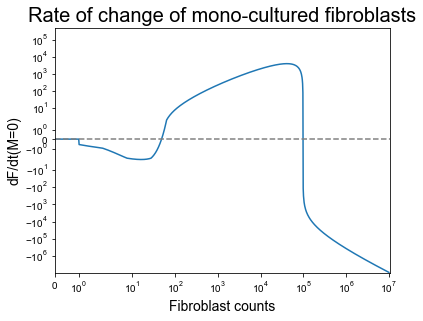

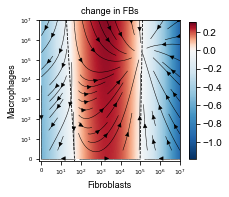

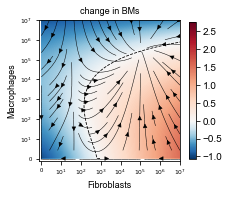

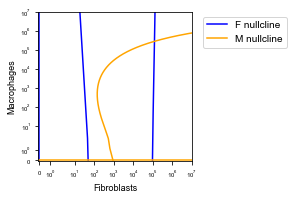

Final fixed points:
[[ 1.05689193e+05  1.89924002e+05]
 [ 2.08395849e+05 -1.00000000e+00]
 [ 4.78870376e+01  0.00000000e+00]
 [ 1.34656220e+05  0.00000000e+00]]
Non-zero final fixed points:
[[5.02403058 5.27857985]
 [1.68021797 0.        ]
 [5.12922642 0.        ]]

Raw nullcline solutions:
[{M: (270.0*F**2 - 4239.0*F + 12403.0)/(10.0*F - 157.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp


Raw nullcline solutions:
[{F: 0.181818181818182*(-100.0*M**2 + 1754.0*M - 23679.0)/(50.0*M - 877.0)}]


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in log10
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in log10


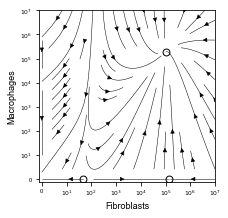

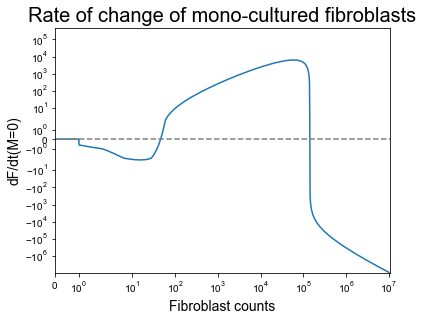

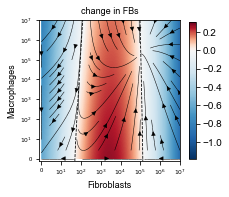

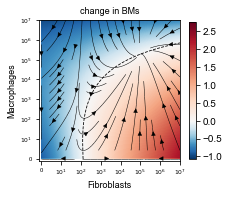

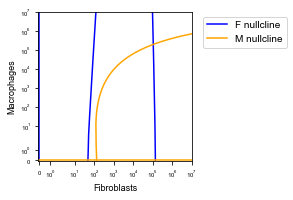

In [39]:
for i, fitted_model in enumerate(analyzed_models):
    _ = analyze_fitted_model(
        fitted_model[0],
        name=fitted_model[1],
        density=0.6,
        rate_minmax_fb=[np.min(fb_min_max[:,0]), np.max(fb_min_max[:,1])],
        rate_minmax_mp=[np.min(mp_min_max[:,0]), np.max(mp_min_max[:,1])]
    )
    plt.show()

## Check the goodness of fit for f(X) = X instead of log(X+1)

In [33]:
dlogFdt_linear = lambda x, pFF, pMF, KF, rF: (pFF*x[0] + pMF*x[1])*(1-x[0]/KF) - rF
dlogF2_linear = lambda x, pFF, pMF, KF, rF: 4*dlogFdt_linear(x, pFF, pMF, KF, rF) + np.log(x[0])
dlogFdt_linear_sym = (pFF*F + pMF*M)*(1-F/KF) - rF

dlogFdt_linear_model = LogDerivModel(
    eq_sym_log_rate=dlogFdt_linear_sym,
    params=[pFF, pMF, KF, rF],
    eq_lam_counts=dlogF2_linear,
    eq_lam_log_rate=dlogFdt_linear,
)

dlogMdt_linear = lambda x, pFM, pMM, KM, rM: (pFM*x[0] + pMM*x[1])*(1-x[1]/KM) - rM
dlogM2_linear = lambda x, pFM, pMM, KM, rM: 4*dlogMdt_linear(x, pFM, pMM, KM, rM) + np.log(x[1])
dlogMdt_linear_sym = (pFM*F + pMM*M)*(1-M/KM) - rM

dlogMdt_linear_model = LogDerivModel(
    eq_sym_log_rate=dlogMdt_linear_sym,
    params=[pFM, pMM, KM, rM],
    eq_lam_counts=dlogM2_linear,
    eq_lam_log_rate=dlogMdt_linear,
)

Number of FB observations: 71 (7 experiments)


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:110: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:114: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0/5000 bootstraps failed to fit


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Whole data single fit: pFF=0.00, pMF=-0.00, KF=2.43, rF=0.00
KF in log10 = 1.06
Median of bootstraps: 0.00, -0.00, 92294.00, 0.00

Number of MP observations: 51 (7 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFM=-0.00, pMM=0.00, KM=0.01, rM=0.00
KM in log10 = 0.01
Median of bootstraps: -0.00, 0.00, 0.08, 0.00




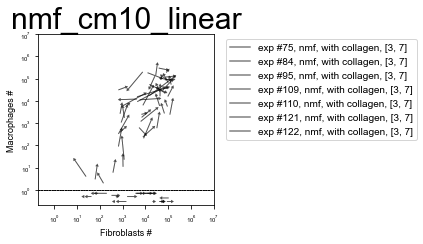

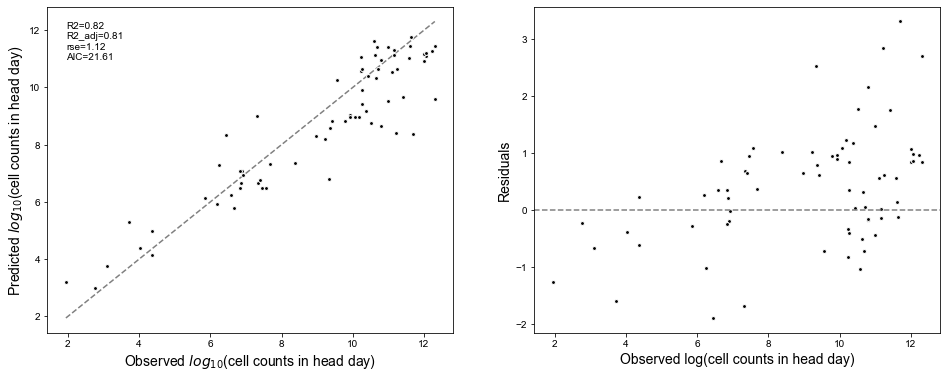

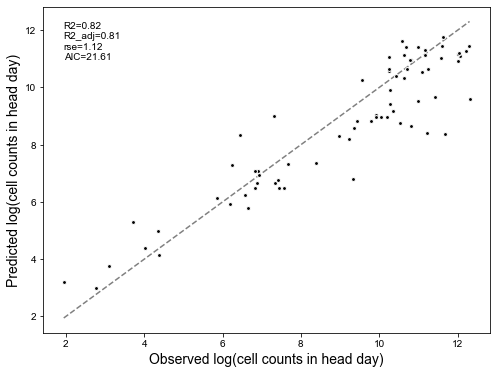

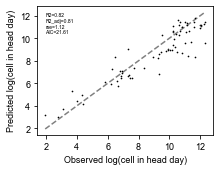

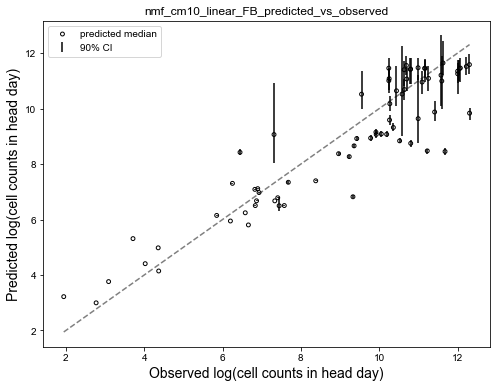

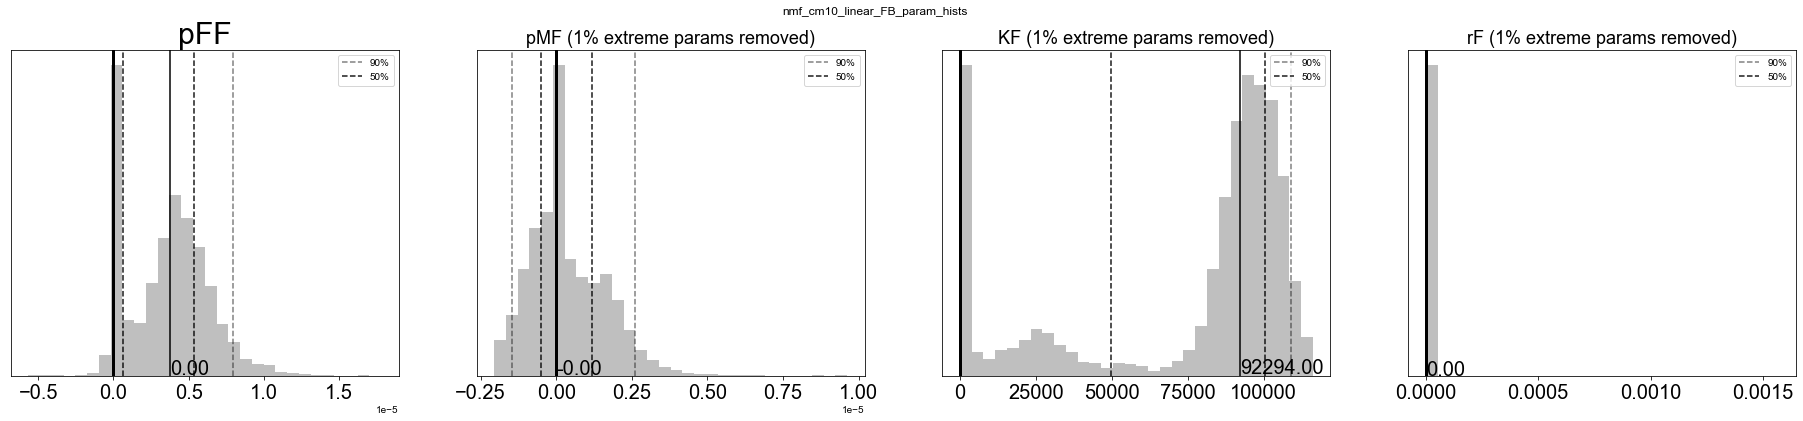

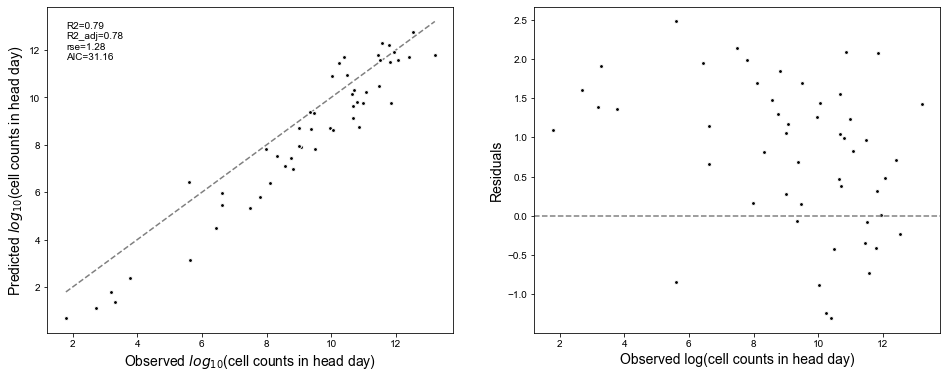

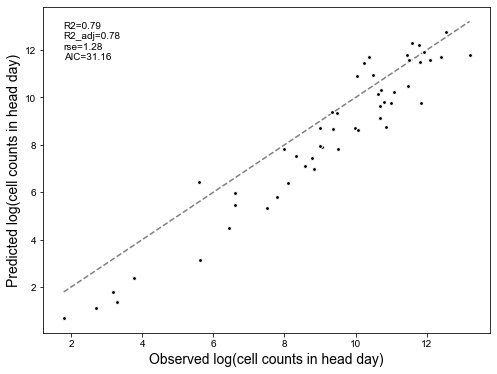

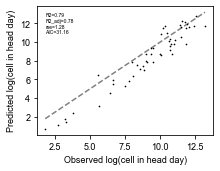

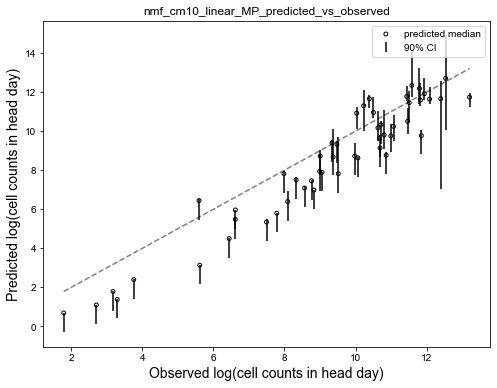

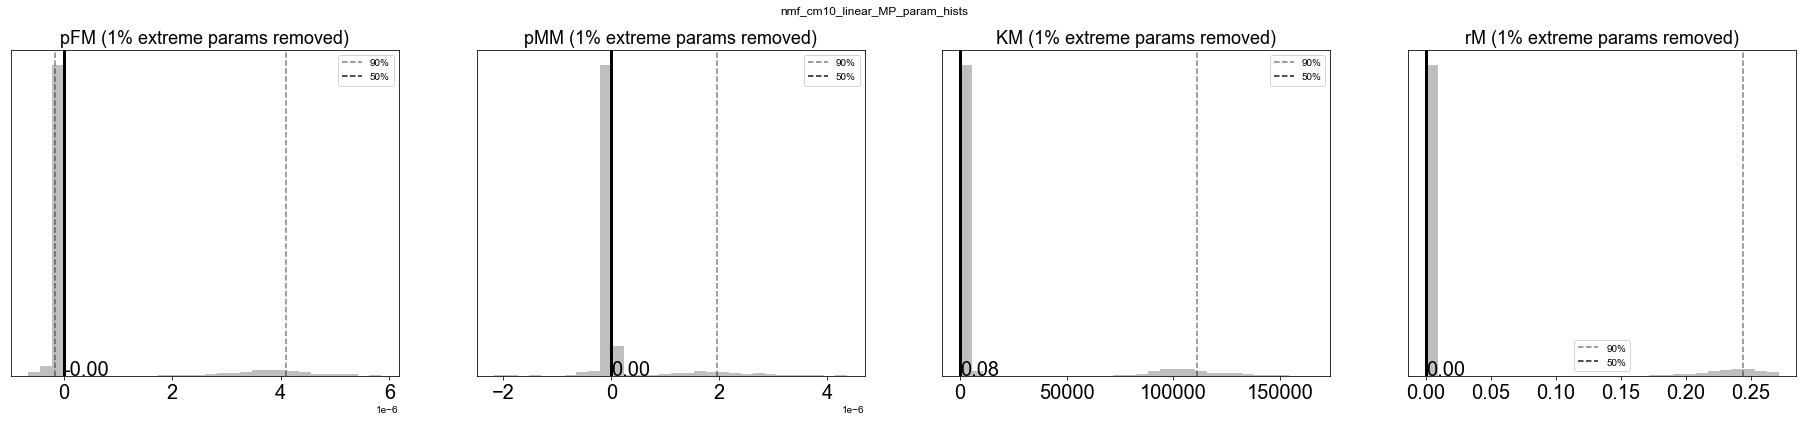

Number of FB observations: 313 (24 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFF=0.00, pMF=0.00, KF=25.15, rF=0.00
KF in log10 = 10.92
Median of bootstraps: 0.00, 0.00, 8.18, 0.00

Number of MP observations: 259 (23 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFM=0.00, pMM=-0.00, KM=235493.10, rM=0.00
KM in log10 = inf
Median of bootstraps: 0.00, -0.00, 231842.69, 0.00




c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:217: RuntimeWarning: overflow encountered in exp


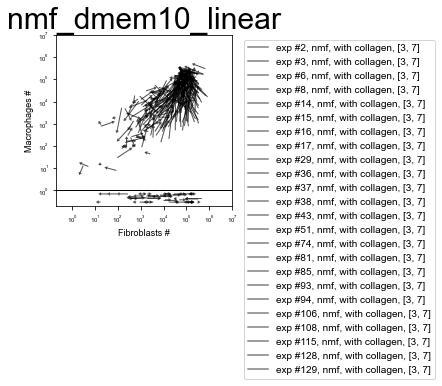

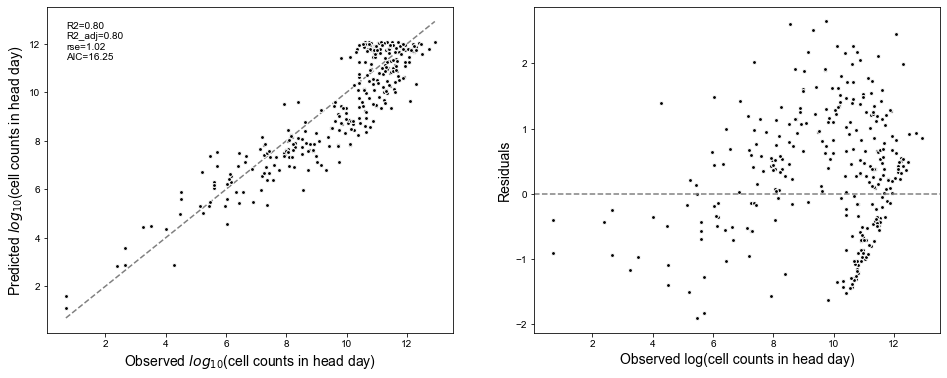

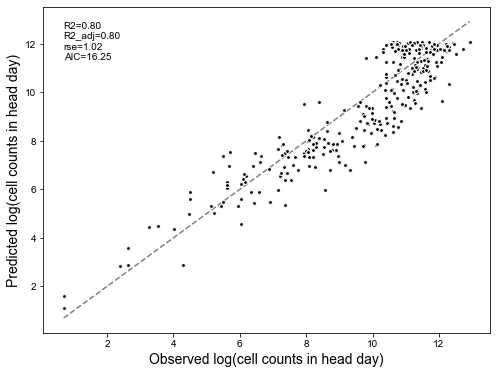

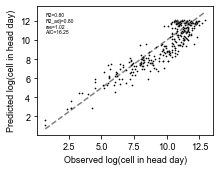

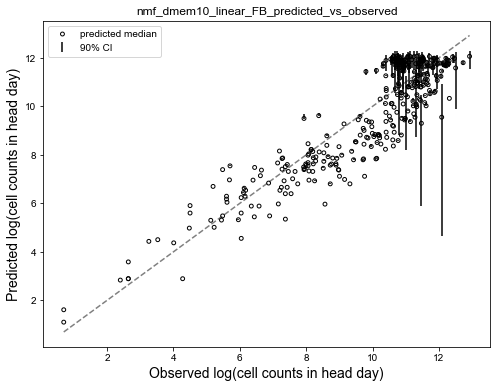

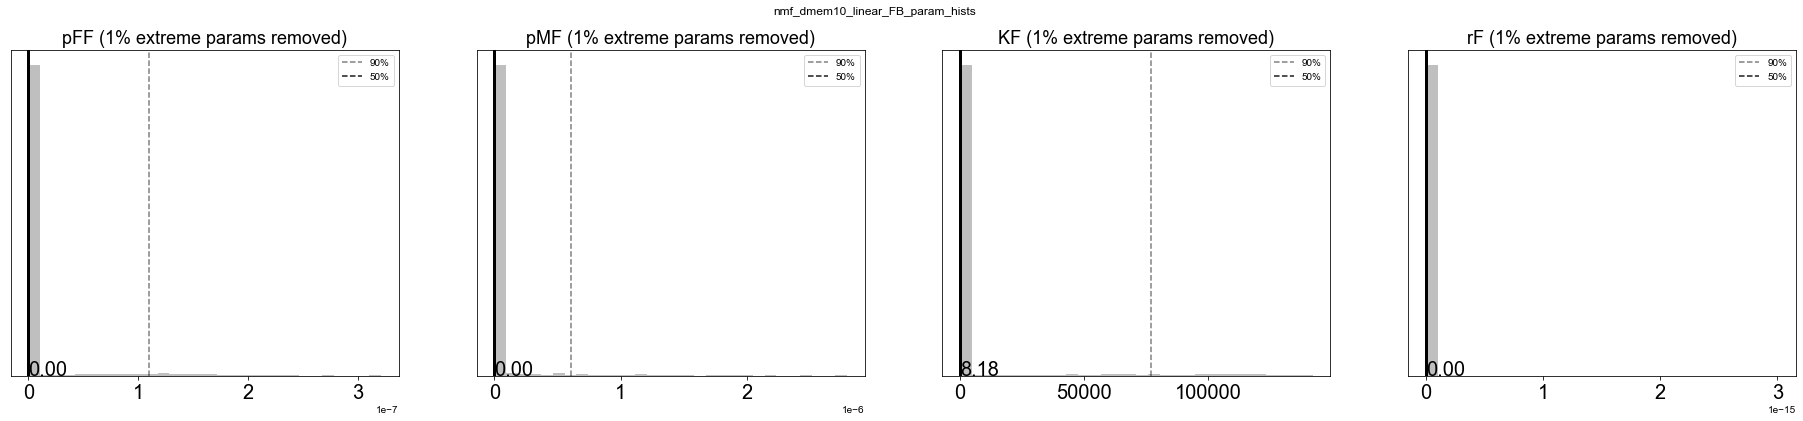

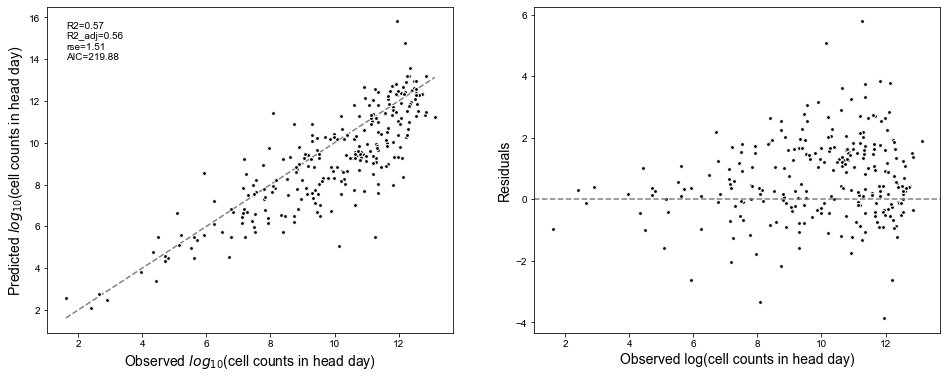

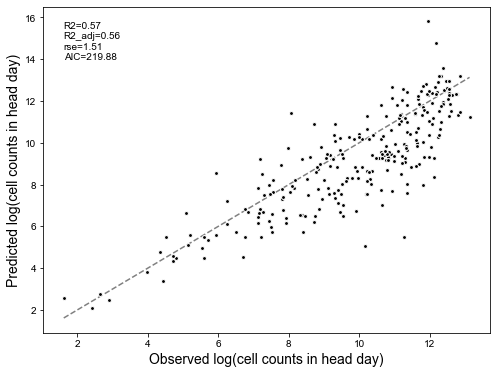

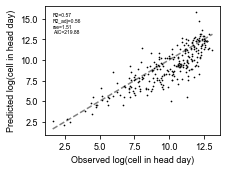

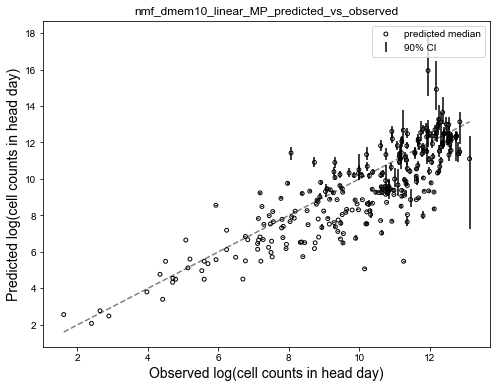

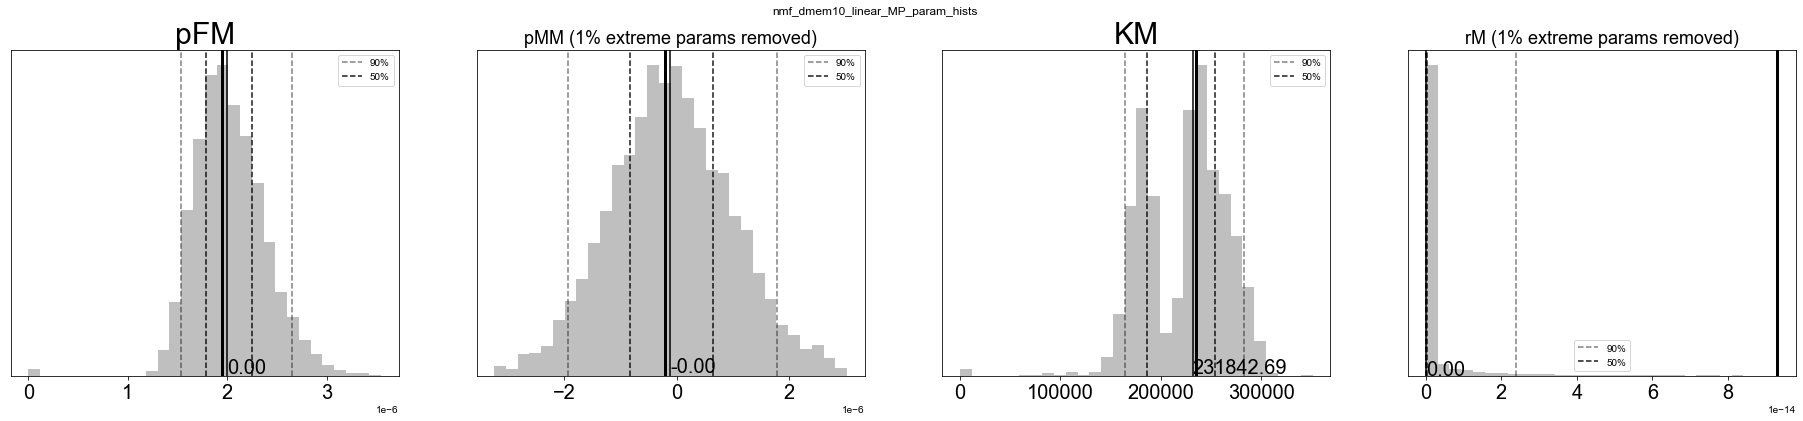

Number of FB observations: 192 (16 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFF=-0.00, pMF=0.00, KF=154071.04, rF=0.00
KF in log10 = inf
Median of bootstraps: -0.00, 0.00, 150985.19, 0.00

Number of MP observations: 165 (15 experiments)


c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:194: RuntimeWarning: overflow encountered in exp


0/5000 bootstraps failed to fit
Whole data single fit: pFM=0.00, pMM=0.00, KM=173043.54, rM=0.00
KM in log10 = inf
Median of bootstraps: 0.00, 0.00, 170527.55, 0.00




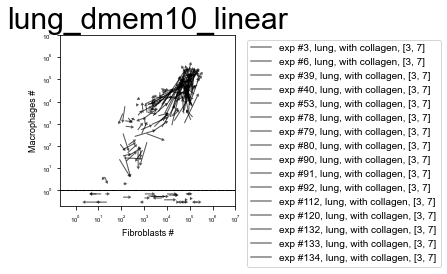

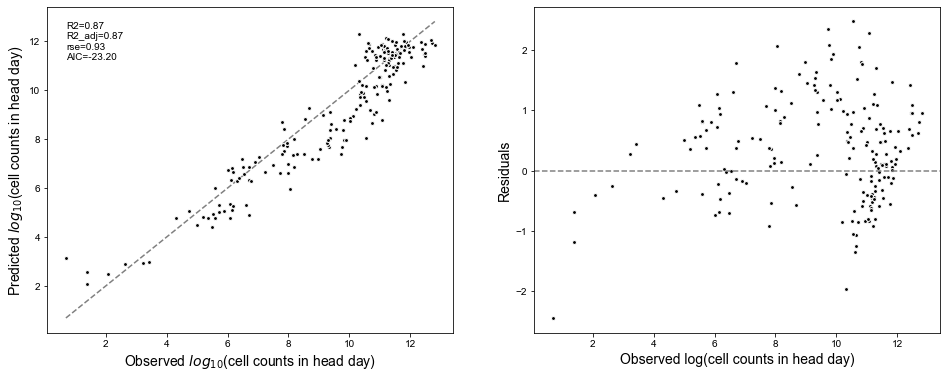

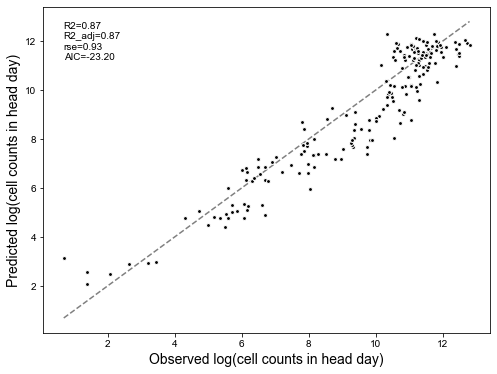

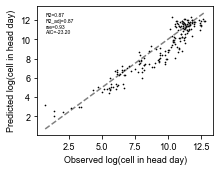

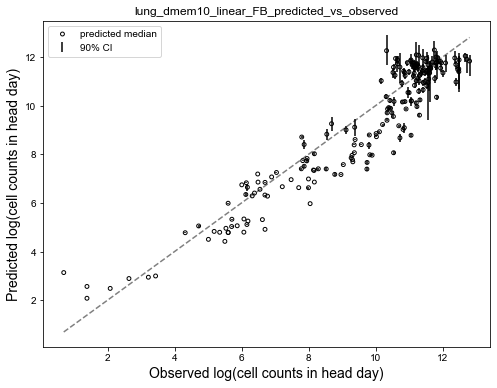

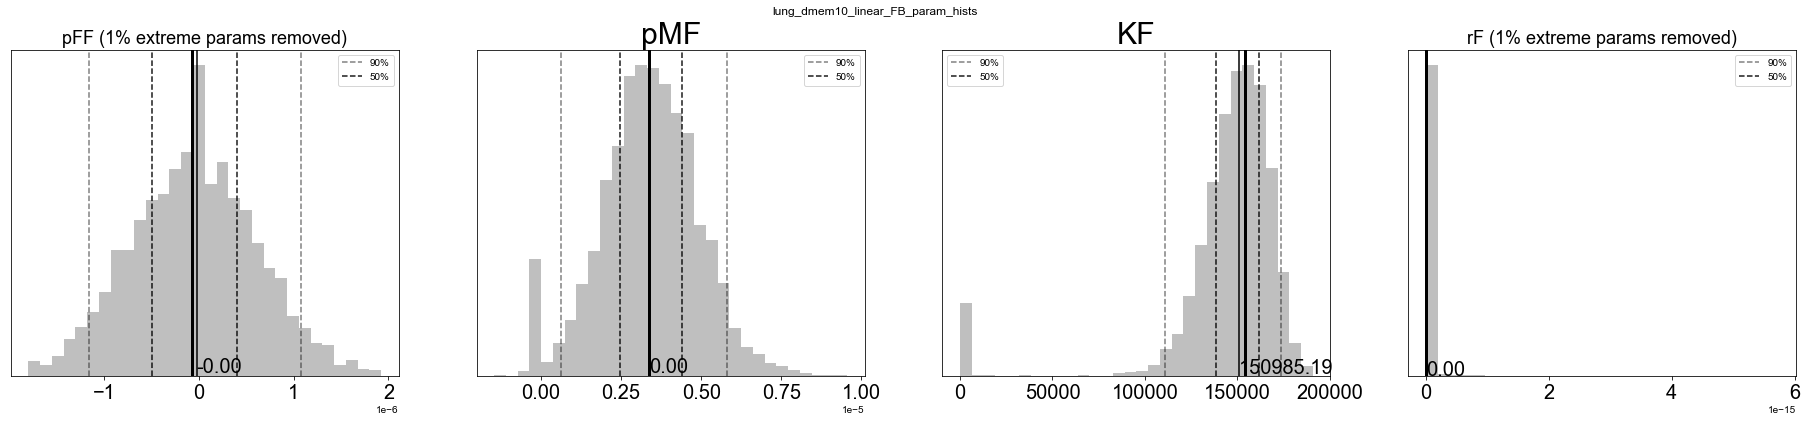

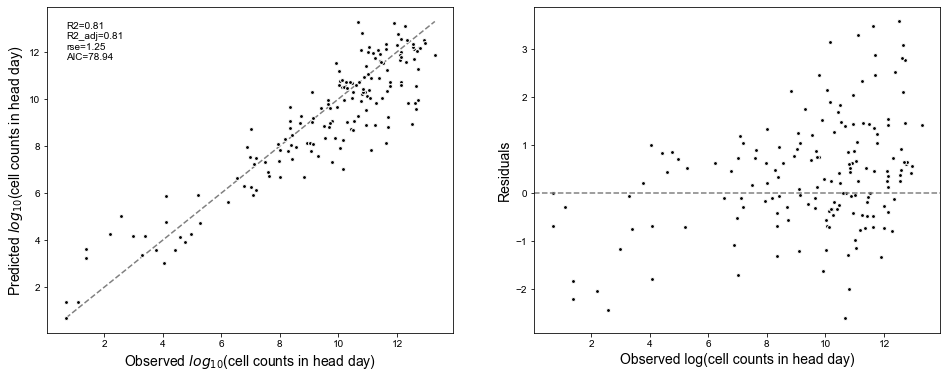

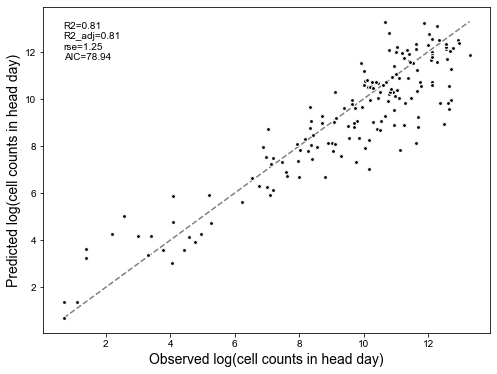

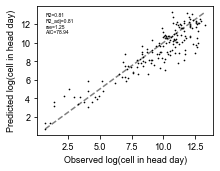

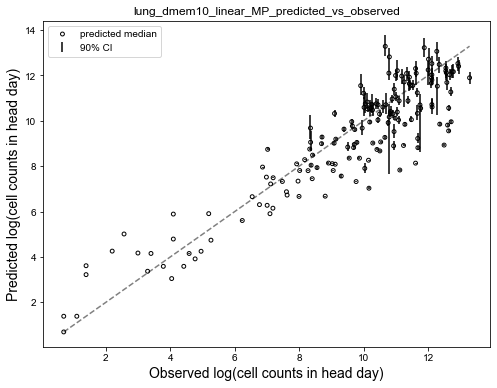

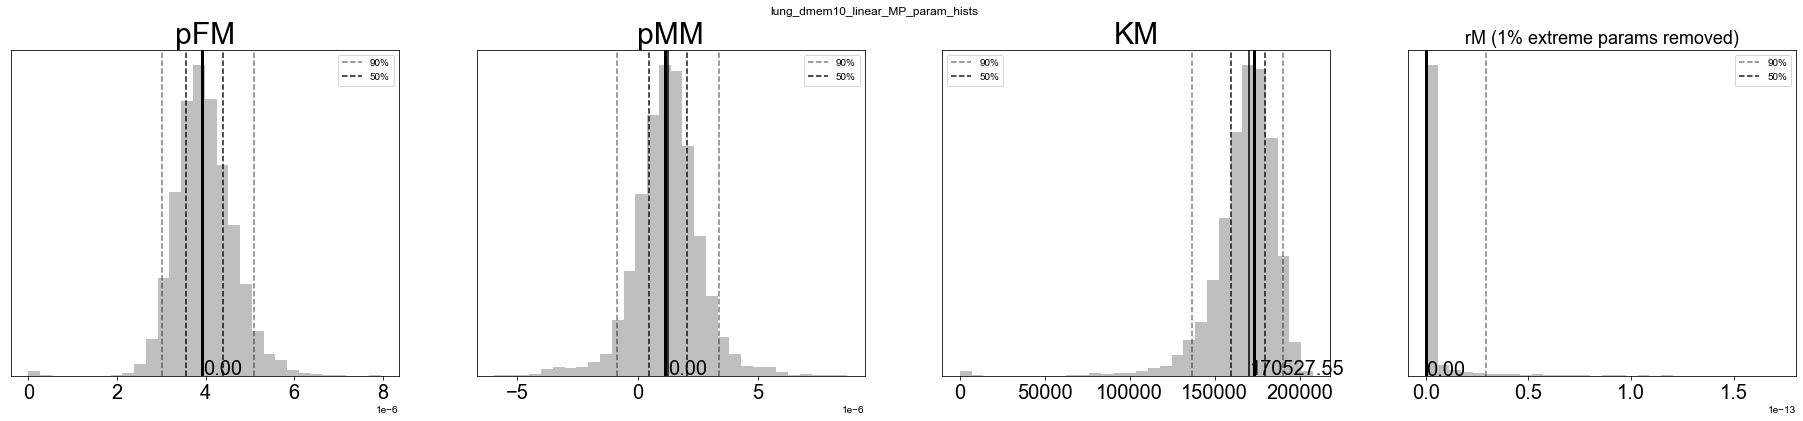

Number of FB observations: 136 (10 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFF=0.00, pMF=0.00, KF=149381.97, rF=0.00
KF in log10 = inf
Median of bootstraps: 0.00, 0.00, 165041.53, 0.00

Number of MP observations: 117 (10 experiments)
0/5000 bootstraps failed to fit
Whole data single fit: pFM=0.00, pMM=0.00, KM=181494.63, rM=0.00
KM in log10 = inf
Median of bootstraps: 0.00, 0.00, 174871.60, 0.00




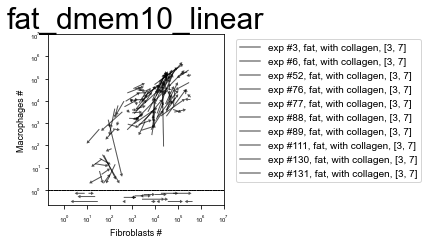

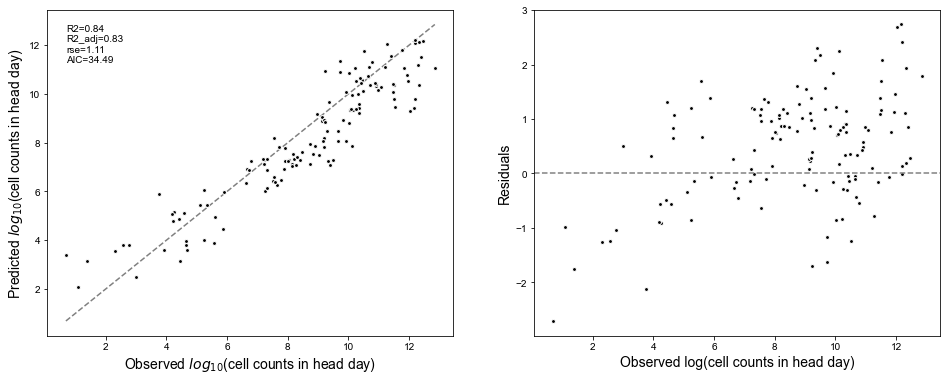

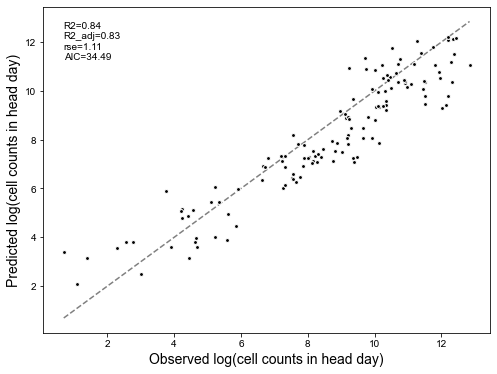

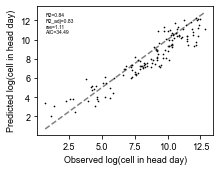

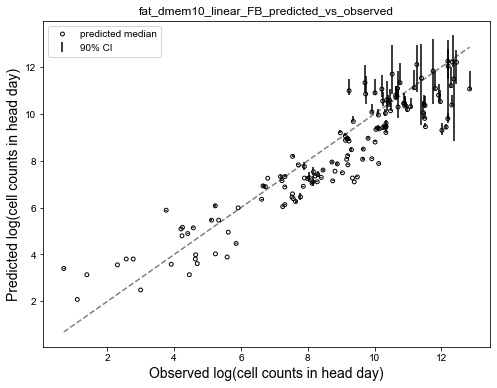

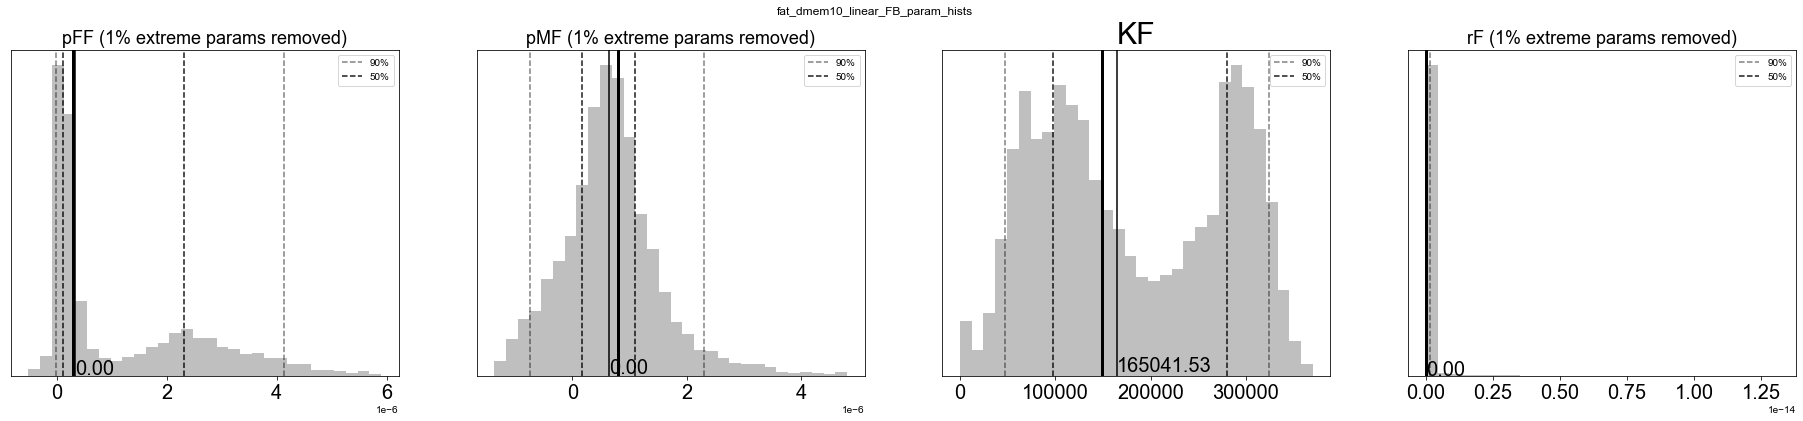

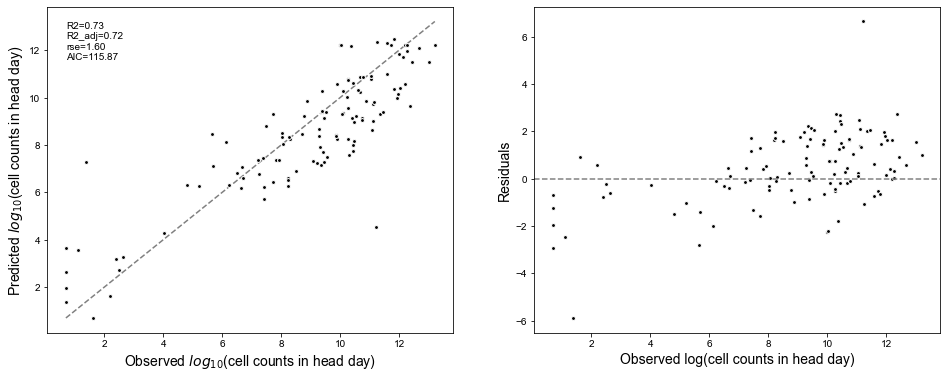

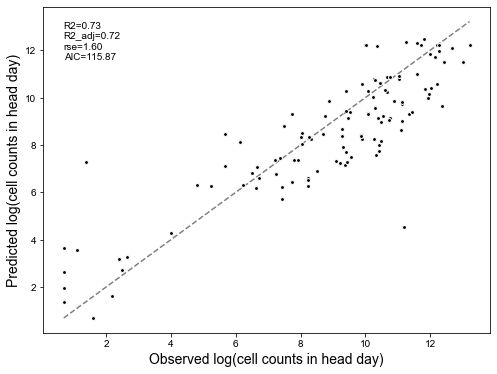

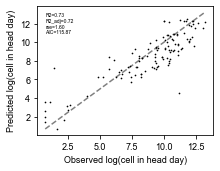

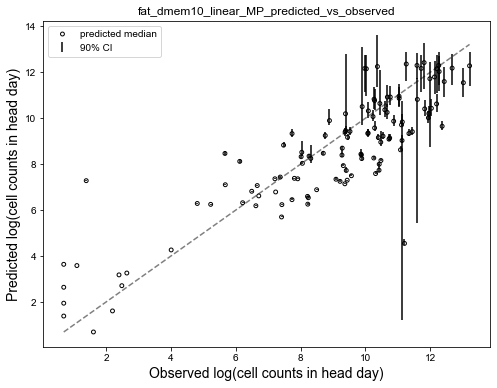

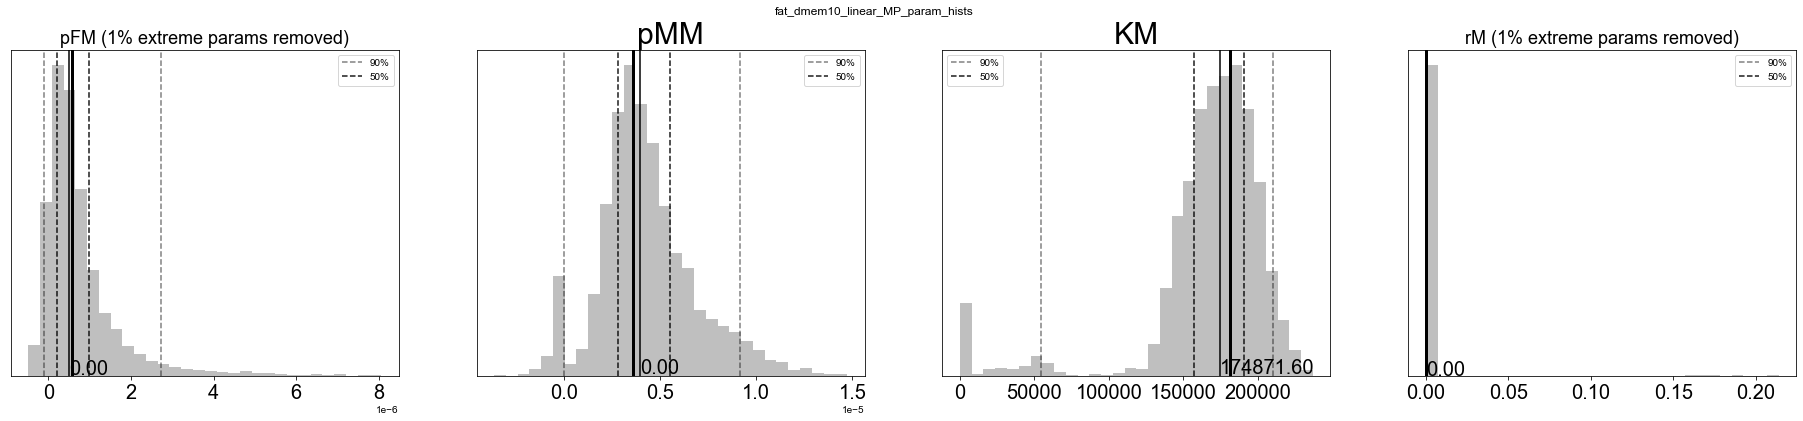

In [34]:
models_linear = []
for organ, medium,  in [
    ['nmf', 'cm10'],
    ['nmf', 'dmem10'],
    ['lung', 'dmem10'],
    ['fat', 'dmem10']
]:
    fitted_model = fit_model(
        dlogFdt_linear_model,
        dlogMdt_linear_model,
        data.loc[(data.medium == medium)],
        cell_type=organ,
        N_boots=5000,
        fb_bounds=([-np.inf, -np.inf, 0, 0], np.inf),
        mp_bounds=([-np.inf, -np.inf, 0, 0], np.inf),
    )
    models_linear.append(fitted_model)
    visualize_fitted_model(fitted_model, mode='paper', name=f'{organ}_{medium}_linear')
    plt.show()

c:\Users\tomerm\Anaconda3\envs\cafs\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


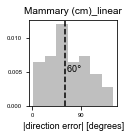

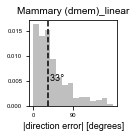

In [35]:
for model, model_name in zip(models_linear, ['Mammary (cm)', 'Mammary (dmem)']):
    plot_direction_error(model, name=f'{model_name}_linear')

# Analyzing PyDREAM results

In [27]:
def plot_trace_plot(chains, param_name, name=None, ax=None, x=None, lw=1):

    if ax is None:
        f, ax = new_fig(size=(4*2, 3*2))

    if x is None:
        x = np.arange(chains.shape[1])
    
    ax.plot(x, chains.T, lw=lw)
    ax.set_title(param_name, size=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if name is not None:
        save_fig(f'../results/{name}')

def plot_trace_plots(chains):
    f, axs = new_fig(size=(4*3*4, 3*3*2), ncols=4, nrows=2)
    axs = axs.flatten()
    for j, param_name in enumerate(['pFF', 'pMF', 'KF', 'rF', 'pMM', 'pFM', 'KM', 'rM']):
        plot_trace_plot(chains[:, :, j], param_name, ax=axs[j])

    f, axs = new_fig(size=(4*3*4, 3*3*2), ncols=4, nrows=2)
    axs = axs.flatten()
    for j, param_name in enumerate(['pFF', 'pMF', 'KF', 'rF', 'pMM', 'pFM', 'KM', 'rM']):
        plot_trace_plot(chains[:, -2000:, j], param_name, ax=axs[j])
    
    plt.show()

    
def plot_param_distributions(chains_list, n=2000):
    
    f, axs = new_fig(size=(4*3*4, 3*3*2), ncols=4, nrows=2)
    axs = axs.flatten()
    for chains in chains_list:
        chains_stacked = np.vstack(chains[:, -n:])
        for j, param_name in zip(range(chains_stacked.shape[1]), ['pFF', 'pMF', 'KF', 'rF', 'pMM', 'pFM', 'KM', 'rM']):
            axs[j].hist(chains_stacked[:, j], bins='auto', alpha=0.5)
            axs[j].set_title(param_name, size=14)

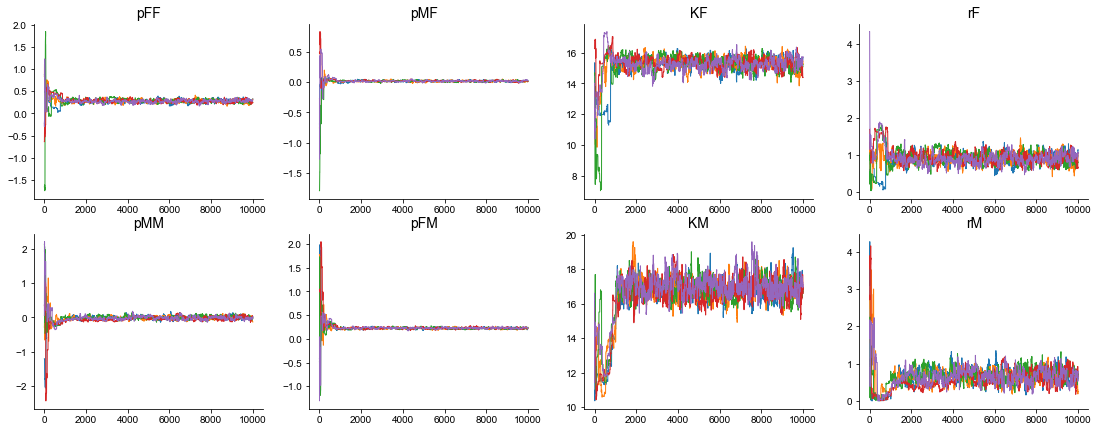

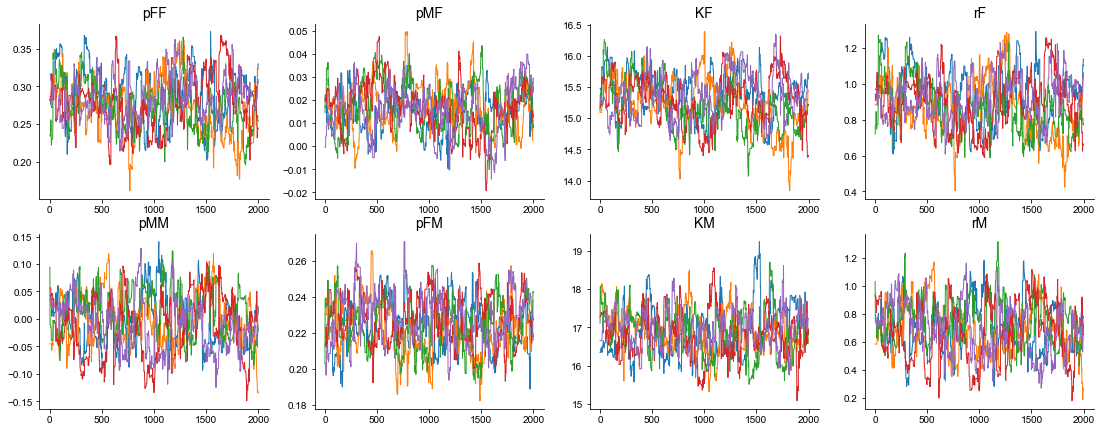

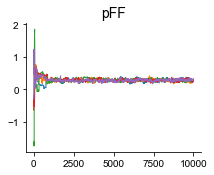

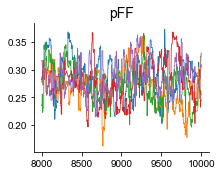

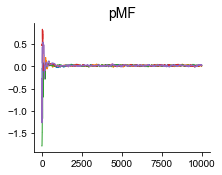

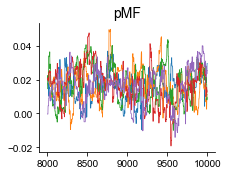

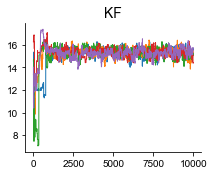

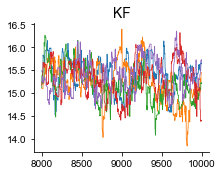

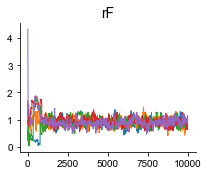

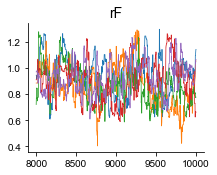

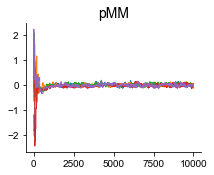

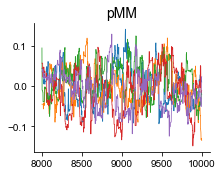

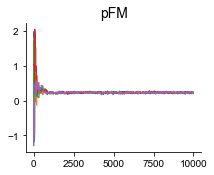

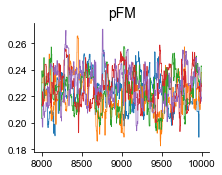

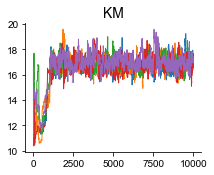

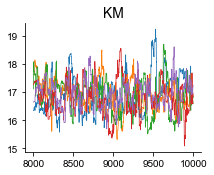

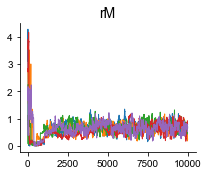

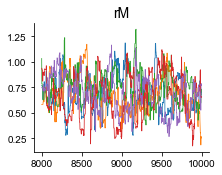

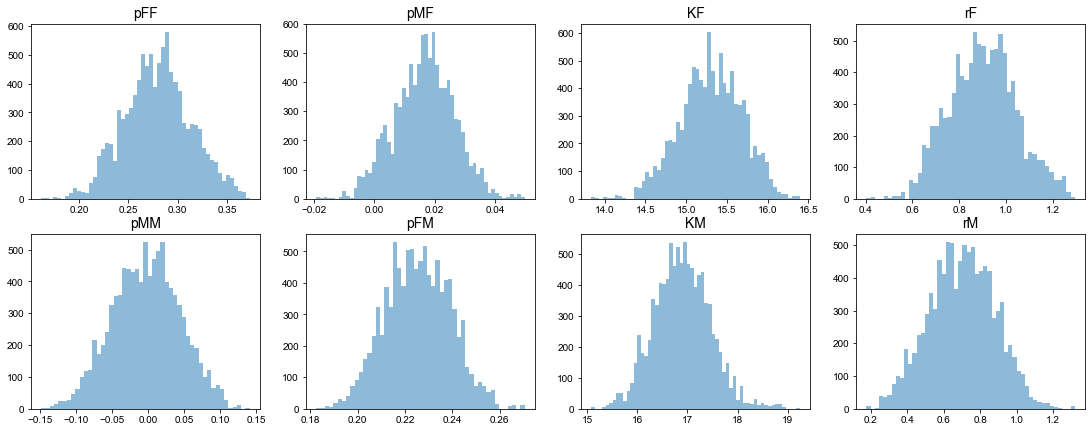

In [31]:
chains_normal = np.array([np.load(
    f'../results/PyDREAM/NMF_DMEM/full_model_logcounts/nmf_dmem_5chain_sampled_params_chain_{i}_10000.npy'
) for i in range(5)])
plot_trace_plots(chains_normal)
for j, param_name in enumerate(['pFF', 'pMF', 'KF', 'rF', 'pMM', 'pFM', 'KM', 'rM']):
        plot_trace_plot(chains_normal[:, :, j], param_name, name=f'param_trace_{param_name}_nmf_dmem')
        plot_trace_plot(chains_normal[:, -2000:, j], param_name, name=f'param_trace_{param_name}_zoom_nmf_dmem', x=np.arange(chains_normal.shape[1])[-2000:], lw=0.75)
plot_param_distributions([chains_normal])

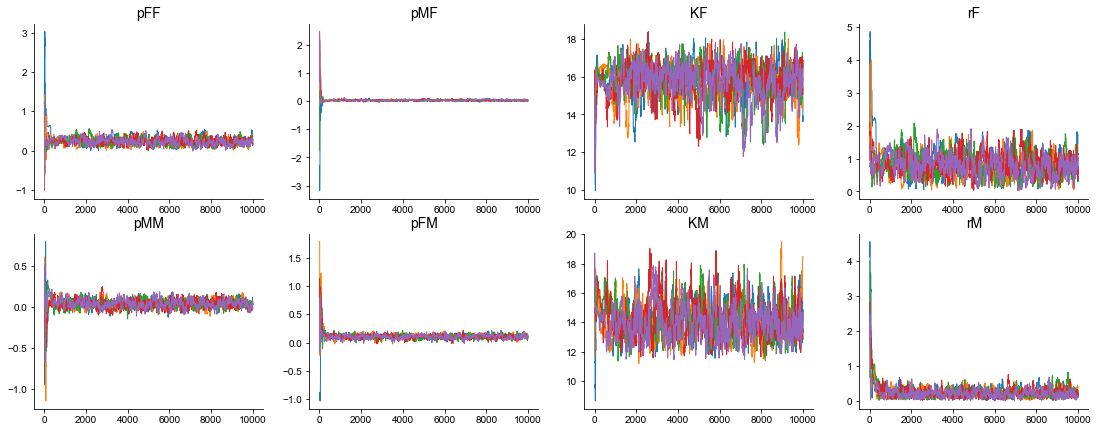

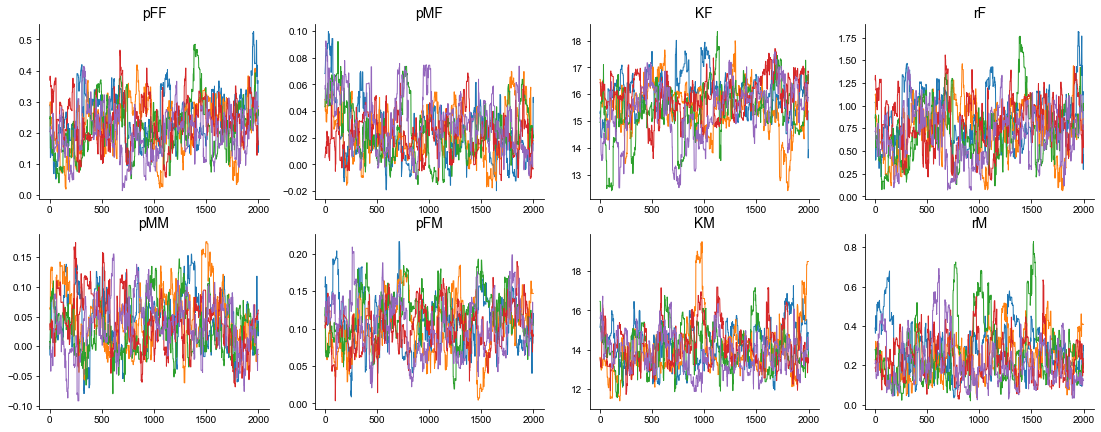

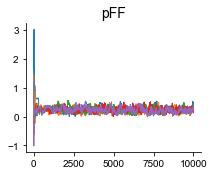

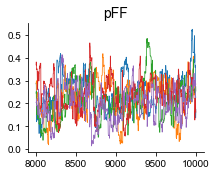

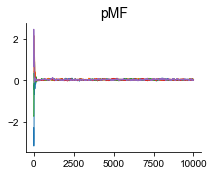

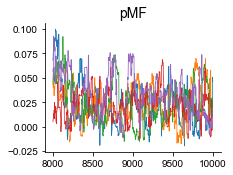

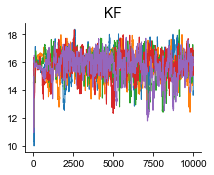

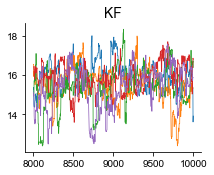

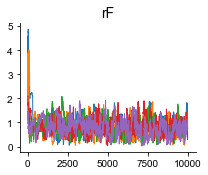

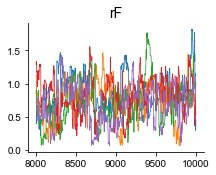

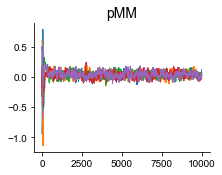

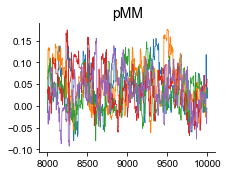

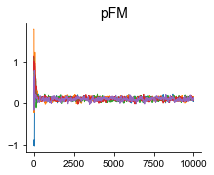

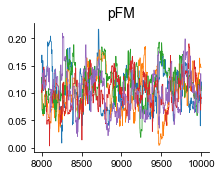

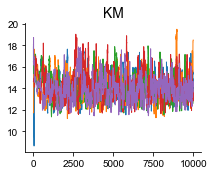

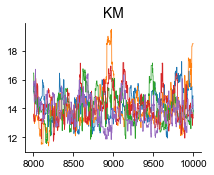

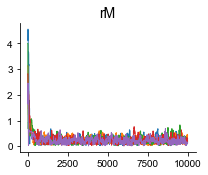

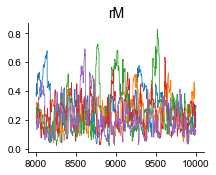

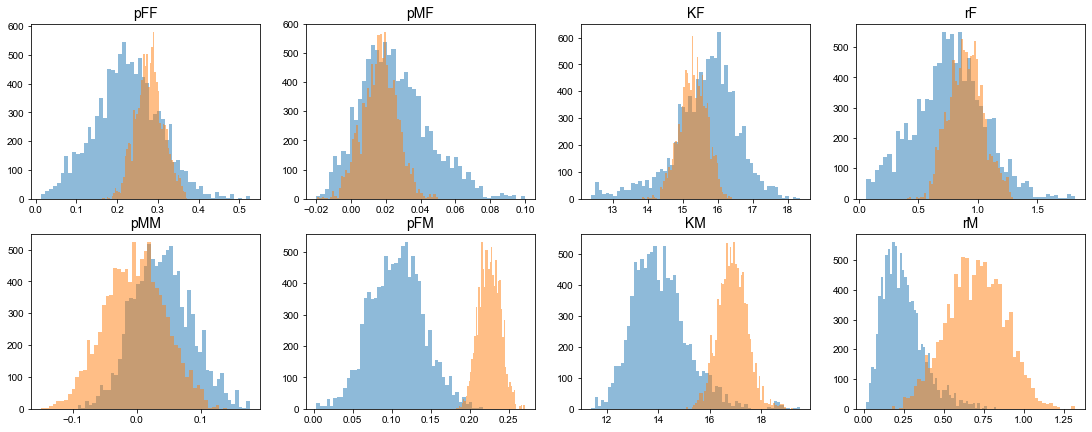

In [32]:
chains_cancer = np.array([np.load(
    f'../results/PyDREAM/NMF_CM/full_model_logcounts/nmf_cm_5chain_sampled_params_chain_{i}_10000.npy'
) for i in range(5)])
plot_trace_plots(chains_cancer)
for j, param_name in enumerate(['pFF', 'pMF', 'KF', 'rF', 'pMM', 'pFM', 'KM', 'rM']):
        plot_trace_plot(chains_cancer[:, :, j], param_name, name=f'param_trace_{param_name}_nmf_cm')
        plot_trace_plot(chains_cancer[:, -2000:, j], param_name, name=f'param_trace_{param_name}_zoom_nmf_cm', x=np.arange(chains_normal.shape[1])[-2000:], lw=0.75)
plot_param_distributions([chains_cancer, chains_normal])

pFF differences:
	Mammary (dmem)>Mammary (cm): p=0.25; Mammary (dmem)<Mammary (cm): p=0.75; effect=1.52+-1.10

pMF differences:
	Mammary (dmem)>Mammary (cm): p=0.62; Mammary (dmem)<Mammary (cm): p=0.38; effect=1.05+-22.07

KF differences:
	Mammary (dmem)>Mammary (cm): p=0.68; Mammary (dmem)<Mammary (cm): p=0.32; effect=0.98+-0.06

rF differences:
	Mammary (dmem)>Mammary (cm): p=0.33; Mammary (dmem)<Mammary (cm): p=0.67; effect=1.54+-1.28

pFM differences:
	Mammary (dmem)>Mammary (cm): p=0.00; Mammary (dmem)<Mammary (cm): p=1.00; effect=2.48+-1.99

pMM differences:
	Mammary (dmem)>Mammary (cm): p=0.73; Mammary (dmem)<Mammary (cm): p=0.27; effect=-0.94+-54.95

KM differences:
	Mammary (dmem)>Mammary (cm): p=0.03; Mammary (dmem)<Mammary (cm): p=0.97; effect=1.21+-0.10

rM differences:
	Mammary (dmem)>Mammary (cm): p=0.02; Mammary (dmem)<Mammary (cm): p=0.98; effect=3.83+-3.01



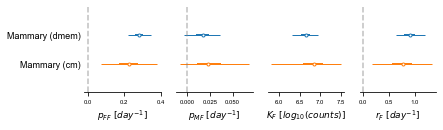

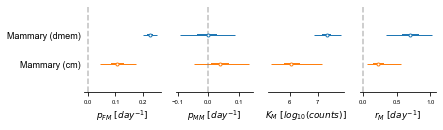

In [37]:
n = 2000
models_from_bayes = []
for chains in [chains_normal, chains_cancer]:
    stacked_chains = np.vstack(chains[:, -n:])
    models_from_bayes.append(Model(
        dxdt_param_samples=stacked_chains[:, :4],
        dxdt_param_names=['pFF', 'pMF', 'KF', 'rF'],
        dydt_param_samples=np.array([stacked_chains[:, 5], stacked_chains[:, 4], stacked_chains[:, 6], stacked_chains[:, 7]]).T,
        dydt_param_names=['pFM', 'pMM', 'KM', 'rM'],
    ))
compare_model_params(
    [
        (models_from_bayes[0], 'Mammary (dmem)', [], []),
        (models_from_bayes[1], 'Mammary (cm)', [], []),
    ],
    ['$p_{FF}\ [day^{-1}]$', '$p_{MF}\ [day^{-1}]$', '$K_F\ [log_{10}(counts)]$', '$r_F\ [day^{-1}]$'],
    ['$p_{FM}\ [day^{-1}]$', '$p_{MM}\ [day^{-1}]$', '$K_M\ [log_{10}(counts)]$', '$r_M\ [day^{-1}]$'],
    name='param_comparison_control_vs_cm_bayes'
)